In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\


C:\Users\User\AppData\Local\Temp\ipykernel_715524\3497385489.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17                  7.66               5.43   
647     8000         13.58  1015.12                  8.11               5.32   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-08 06:19:59,178] A new study created in memory with name: no-name-36596684-3f31-449b-bd86-6ae71f64fa10
[I 2025-06-08 06:25:36,693] Trial 0 finished with value: 1.2687028288841247 and parameters: {'lr': 0.33250569810295943, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2713915728798961}. Best is trial 0 with value: 1.2687028288841247.


Cross Validation Accuracies:
[1.0999677181243896, 1.7172565460205078, 0.64569491147995, 1.5561659336090088, 1.3244290351867676]
Mean Cross Validation Accuracy:
1.2687028288841247
Standard Deviation of Cross Validation Accuracy:
0.3751136591901734


[I 2025-06-08 06:30:26,713] Trial 1 finished with value: 0.11792072653770447 and parameters: {'lr': 0.0017976315999661046, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45404568602558426}. Best is trial 1 with value: 0.11792072653770447.


Cross Validation Accuracies:
[0.15989463031291962, 0.11364911496639252, 0.10637018084526062, 0.10748099535703659, 0.102208711206913]
Mean Cross Validation Accuracy:
0.11792072653770447
Standard Deviation of Cross Validation Accuracy:
0.02130411125684456


[I 2025-06-08 06:35:34,880] Trial 2 finished with value: 5.283751678466797 and parameters: {'lr': 0.05940117056257137, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4858800795924556}. Best is trial 1 with value: 0.11792072653770447.


Cross Validation Accuracies:
[5.084376811981201, 6.33488130569458, 6.256771087646484, 5.300715923309326, 3.4420132637023926]
Mean Cross Validation Accuracy:
5.283751678466797
Standard Deviation of Cross Validation Accuracy:
1.0472515242561868


[I 2025-06-08 06:41:34,260] Trial 3 finished with value: 0.099247045814991 and parameters: {'lr': 0.00582738398227044, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.44205396025396115}. Best is trial 3 with value: 0.099247045814991.


Cross Validation Accuracies:
[0.14582203328609467, 0.10258795320987701, 0.09975825250148773, 0.0767202079296112, 0.07134678214788437]
Mean Cross Validation Accuracy:
0.099247045814991
Standard Deviation of Cross Validation Accuracy:
0.02633072574100167


[I 2025-06-08 06:46:17,445] Trial 4 finished with value: 2.83712420463562 and parameters: {'lr': 0.02941318921085484, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2779503239139347}. Best is trial 3 with value: 0.099247045814991.


Cross Validation Accuracies:
[2.6789822578430176, 2.7148897647857666, 2.7618064880371094, 3.0036842823028564, 3.0262582302093506]
Mean Cross Validation Accuracy:
2.83712420463562
Standard Deviation of Cross Validation Accuracy:
0.14774087528955263


[I 2025-06-08 06:51:15,759] Trial 5 finished with value: 0.09211519807577133 and parameters: {'lr': 0.001014074785419959, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2193171431148663}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.13680583238601685, 0.0853734016418457, 0.09755247086286545, 0.07074929028749466, 0.070094995200634]
Mean Cross Validation Accuracy:
0.09211519807577133
Standard Deviation of Cross Validation Accuracy:
0.024550600399376014


[I 2025-06-08 06:56:43,653] Trial 6 finished with value: 0.30934205651283264 and parameters: {'lr': 0.5789096220417816, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3937327385407714}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.32818904519081116, 0.3112241327762604, 0.3086385428905487, 0.3260589838027954, 0.27259957790374756]
Mean Cross Validation Accuracy:
0.30934205651283264
Standard Deviation of Cross Validation Accuracy:
0.01994347771610019


[I 2025-06-08 07:03:16,568] Trial 7 finished with value: 0.09775571376085282 and parameters: {'lr': 0.037350113639921335, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16551895076923379}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.13971510529518127, 0.08682608604431152, 0.10221555829048157, 0.08136679232120514, 0.07865502685308456]
Mean Cross Validation Accuracy:
0.09775571376085282
Standard Deviation of Cross Validation Accuracy:
0.02250942246920278


[I 2025-06-08 07:08:22,103] Trial 8 finished with value: 0.1399516075849533 and parameters: {'lr': 0.01955600102432581, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14614577114039795}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.1720680296421051, 0.07970920950174332, 0.16786430776119232, 0.15922623872756958, 0.12089025229215622]
Mean Cross Validation Accuracy:
0.1399516075849533
Standard Deviation of Cross Validation Accuracy:
0.03514136193996988


[I 2025-06-08 07:13:21,650] Trial 9 finished with value: 0.15876624286174773 and parameters: {'lr': 0.03888620432893705, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.46985180325804243}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.2115522027015686, 0.17505280673503876, 0.1061159074306488, 0.17835202813148499, 0.12275826930999756]
Mean Cross Validation Accuracy:
0.15876624286174773
Standard Deviation of Cross Validation Accuracy:
0.03873975912148396


[I 2025-06-08 07:18:36,597] Trial 10 finished with value: 0.5802917122840882 and parameters: {'lr': 0.001021687049498702, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.21401441925149783}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.5206337571144104, 0.5923864245414734, 0.588252067565918, 0.5950937867164612, 0.6050925254821777]
Mean Cross Validation Accuracy:
0.5802917122840882
Standard Deviation of Cross Validation Accuracy:
0.030341070115001634


[I 2025-06-08 07:24:23,965] Trial 11 finished with value: 0.09603034257888794 and parameters: {'lr': 0.007478194580002391, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10555265675271402}. Best is trial 5 with value: 0.09211519807577133.


Cross Validation Accuracies:
[0.14406010508537292, 0.08561909198760986, 0.10000424087047577, 0.0790218785405159, 0.07144639641046524]
Mean Cross Validation Accuracy:
0.09603034257888794
Standard Deviation of Cross Validation Accuracy:
0.025786439657665514


[I 2025-06-08 07:30:02,790] Trial 12 finished with value: 0.08500066250562668 and parameters: {'lr': 0.0037285053014042163, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10068020624354942}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.13090157508850098, 0.08910307288169861, 0.08218105137348175, 0.06033555790781975, 0.06248205527663231]
Mean Cross Validation Accuracy:
0.08500066250562668
Standard Deviation of Cross Validation Accuracy:
0.025483833346360434


[I 2025-06-08 07:35:10,400] Trial 13 finished with value: 0.09617246836423873 and parameters: {'lr': 0.0028528682374146016, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3407982804485474}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.138200044631958, 0.08762573450803757, 0.1013108640909195, 0.0753667950630188, 0.07835890352725983]
Mean Cross Validation Accuracy:
0.09617246836423873
Standard Deviation of Cross Validation Accuracy:
0.022873417195119816


[I 2025-06-08 07:40:56,313] Trial 14 finished with value: 0.09153899997472763 and parameters: {'lr': 0.004861110613401737, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21125361306923535}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.14217156171798706, 0.06574102491140366, 0.10106133669614792, 0.07912090420722961, 0.0696001723408699]
Mean Cross Validation Accuracy:
0.09153899997472763
Standard Deviation of Cross Validation Accuracy:
0.028126101696210392


[I 2025-06-08 07:47:11,426] Trial 15 finished with value: 0.09595830142498016 and parameters: {'lr': 0.00810698057720615, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2073582915795678}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.14552192389965057, 0.08680757880210876, 0.10181844234466553, 0.07741072028875351, 0.06823284178972244]
Mean Cross Validation Accuracy:
0.09595830142498016
Standard Deviation of Cross Validation Accuracy:
0.027156375041312752


[I 2025-06-08 07:52:58,886] Trial 16 finished with value: 0.44683548212051394 and parameters: {'lr': 0.003762876150213071, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10305068196044435}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.37082961201667786, 0.47313642501831055, 0.45815542340278625, 0.48337751626968384, 0.4486784338951111]
Mean Cross Validation Accuracy:
0.44683548212051394
Standard Deviation of Cross Validation Accuracy:
0.0398383977820169


[I 2025-06-08 07:58:51,896] Trial 17 finished with value: 0.09657115638256072 and parameters: {'lr': 0.10744218591956224, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14646717447839358}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.14138959348201752, 0.09067445993423462, 0.09816312044858932, 0.08040828257799149, 0.0722203254699707]
Mean Cross Validation Accuracy:
0.09657115638256072
Standard Deviation of Cross Validation Accuracy:
0.024084016020527694


[I 2025-06-08 08:05:01,730] Trial 18 finished with value: 0.0978476122021675 and parameters: {'lr': 0.01227652910437198, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3248610303545786}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.14471592009067535, 0.09075275808572769, 0.10166136920452118, 0.08077267557382584, 0.0713353380560875]
Mean Cross Validation Accuracy:
0.0978476122021675
Standard Deviation of Cross Validation Accuracy:
0.02551851924778285


[I 2025-06-08 08:10:57,497] Trial 19 finished with value: 0.5238370299339294 and parameters: {'lr': 0.002667756338520577, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.18936363872241213}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.46205395460128784, 0.527600109577179, 0.5370155572891235, 0.5493201017379761, 0.5431954264640808]
Mean Cross Validation Accuracy:
0.5238370299339294
Standard Deviation of Cross Validation Accuracy:
0.03171471965507713


[I 2025-06-08 08:16:46,611] Trial 20 finished with value: 0.097718845307827 and parameters: {'lr': 0.014932051231240953, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25949328821305545}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.14278008043766022, 0.08598094433546066, 0.10921510308980942, 0.0784587636590004, 0.07215933501720428]
Mean Cross Validation Accuracy:
0.097718845307827
Standard Deviation of Cross Validation Accuracy:
0.02578641690917488


[I 2025-06-08 08:21:52,189] Trial 21 finished with value: 0.08842233419418336 and parameters: {'lr': 0.001035321835885152, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23875728895042003}. Best is trial 12 with value: 0.08500066250562668.


Cross Validation Accuracies:
[0.10969410836696625, 0.08692832291126251, 0.09782493114471436, 0.0764649361371994, 0.07119937241077423]
Mean Cross Validation Accuracy:
0.08842233419418336
Standard Deviation of Cross Validation Accuracy:
0.014019551037543519


[I 2025-06-08 08:26:55,974] Trial 22 finished with value: 0.07475238144397736 and parameters: {'lr': 0.0016798806521673634, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.24132562132523228}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.0709017738699913, 0.06842195987701416, 0.07920826226472855, 0.08751707524061203, 0.06771283596754074]
Mean Cross Validation Accuracy:
0.07475238144397736
Standard Deviation of Cross Validation Accuracy:
0.0075795632859646045


[I 2025-06-08 08:32:10,335] Trial 23 finished with value: 0.08533958196640015 and parameters: {'lr': 0.0017452353189221295, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.35368125167807996}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.08679034560918808, 0.09336689114570618, 0.10034295916557312, 0.07375728338956833, 0.07244043052196503]
Mean Cross Validation Accuracy:
0.08533958196640015
Standard Deviation of Cross Validation Accuracy:
0.010882844145694844


[I 2025-06-08 08:37:18,237] Trial 24 finished with value: 0.09419932514429093 and parameters: {'lr': 0.0020182986306061155, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3764240114991029}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.13643185794353485, 0.08566277474164963, 0.1051713302731514, 0.07359575480222702, 0.07013490796089172]
Mean Cross Validation Accuracy:
0.09419932514429093
Standard Deviation of Cross Validation Accuracy:
0.02441494501808613


[I 2025-06-08 08:42:31,569] Trial 25 finished with value: 0.09863587915897369 and parameters: {'lr': 0.0017270315319764576, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4039233075882531}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.13715001940727234, 0.08166232705116272, 0.09449674189090729, 0.07759681344032288, 0.10227349400520325]
Mean Cross Validation Accuracy:
0.09863587915897369
Standard Deviation of Cross Validation Accuracy:
0.021187012321841444


[I 2025-06-08 08:47:59,981] Trial 26 finished with value: 0.07899828106164933 and parameters: {'lr': 0.0037724266212080535, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3074044260722524}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.09942665696144104, 0.08698652684688568, 0.059070438146591187, 0.07870583981275558, 0.07080194354057312]
Mean Cross Validation Accuracy:
0.07899828106164933
Standard Deviation of Cross Validation Accuracy:
0.013751472695818629


[I 2025-06-08 08:53:05,774] Trial 27 finished with value: 0.10167283713817596 and parameters: {'lr': 0.011927264470990543, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.32311780924267935}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.14927004277706146, 0.09295830875635147, 0.10359247773885727, 0.07904669642448425, 0.08349665999412537]
Mean Cross Validation Accuracy:
0.10167283713817596
Standard Deviation of Cross Validation Accuracy:
0.02524851547616789


[I 2025-06-08 08:58:28,583] Trial 28 finished with value: 0.09654728919267655 and parameters: {'lr': 0.003889016673784351, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.27698377971303717}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.14361757040023804, 0.08638026565313339, 0.10126146674156189, 0.08029494434595108, 0.07118219882249832]
Mean Cross Validation Accuracy:
0.09654728919267655
Standard Deviation of Cross Validation Accuracy:
0.02549011468424239


[I 2025-06-08 09:03:55,899] Trial 29 finished with value: 0.13474820852279662 and parameters: {'lr': 0.17147538206153476, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.30346935724393326}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.15904302895069122, 0.12802095711231232, 0.16230541467666626, 0.1235329806804657, 0.10083866119384766]
Mean Cross Validation Accuracy:
0.13474820852279662
Standard Deviation of Cross Validation Accuracy:
0.02311074450458056


[I 2025-06-08 09:08:46,743] Trial 30 finished with value: 0.09697481095790864 and parameters: {'lr': 0.006109999238329469, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.24838637232037583}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.14133867621421814, 0.09202952682971954, 0.09654903411865234, 0.08280360698699951, 0.07215321063995361]
Mean Cross Validation Accuracy:
0.09697481095790864
Standard Deviation of Cross Validation Accuracy:
0.02370537713614684


[I 2025-06-08 09:13:52,422] Trial 31 finished with value: 0.09846631735563278 and parameters: {'lr': 0.001924480479293099, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3498318419796044}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.14614199101924896, 0.0940539762377739, 0.10281010717153549, 0.07886713743209839, 0.07045837491750717]
Mean Cross Validation Accuracy:
0.09846631735563278
Standard Deviation of Cross Validation Accuracy:
0.026381356358902947


[I 2025-06-08 09:19:03,008] Trial 32 finished with value: 0.09043823927640915 and parameters: {'lr': 0.0031556839208546684, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.36553648512549597}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.13639280200004578, 0.08659190684556961, 0.07916601002216339, 0.07939008623361588, 0.07065039128065109]
Mean Cross Validation Accuracy:
0.09043823927640915
Standard Deviation of Cross Validation Accuracy:
0.023525730061401552


[I 2025-06-08 09:24:31,464] Trial 33 finished with value: 0.09051569402217866 and parameters: {'lr': 0.0016373095256348076, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2986110738618367}. Best is trial 22 with value: 0.07475238144397736.


Cross Validation Accuracies:
[0.13177038729190826, 0.07196446508169174, 0.09940347075462341, 0.07970645278692245, 0.06973369419574738]
Mean Cross Validation Accuracy:
0.09051569402217866
Standard Deviation of Cross Validation Accuracy:
0.02312497178417899


[I 2025-06-08 09:29:30,930] Trial 34 finished with value: 0.06754790991544724 and parameters: {'lr': 0.0013700834759462605, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.42473706728833627}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.09133554250001907, 0.05911608040332794, 0.06274697929620743, 0.06133072078227997, 0.06321022659540176]
Mean Cross Validation Accuracy:
0.06754790991544724
Standard Deviation of Cross Validation Accuracy:
0.011978857082487944


[I 2025-06-08 09:34:10,423] Trial 35 finished with value: 0.5830477714538574 and parameters: {'lr': 0.009509579735074726, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4237373595220192}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.7613925337791443, 0.5443583130836487, 0.5684664845466614, 0.5002854466438293, 0.5407360792160034]
Mean Cross Validation Accuracy:
0.5830477714538574
Standard Deviation of Cross Validation Accuracy:
0.09182181012559555


[I 2025-06-08 09:38:29,806] Trial 36 finished with value: 0.09728779345750808 and parameters: {'lr': 0.004774292829100763, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.44750102335010455}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.149781733751297, 0.08846721053123474, 0.0964297354221344, 0.08072434365749359, 0.0710359439253807]
Mean Cross Validation Accuracy:
0.09728779345750808
Standard Deviation of Cross Validation Accuracy:
0.02755960880511284


[I 2025-06-08 09:43:23,169] Trial 37 finished with value: 0.10786251872777938 and parameters: {'lr': 0.0014695242279708636, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.49240992473681355}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.14045991003513336, 0.11776085942983627, 0.11111200600862503, 0.10661732405424118, 0.0633624941110611]
Mean Cross Validation Accuracy:
0.10786251872777938
Standard Deviation of Cross Validation Accuracy:
0.025111467248851358


[I 2025-06-08 09:48:12,025] Trial 38 finished with value: 0.07797362804412841 and parameters: {'lr': 0.00256580165975254, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4226557930231674}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.08603715896606445, 0.08516225218772888, 0.06961534172296524, 0.08252489566802979, 0.06652849167585373]
Mean Cross Validation Accuracy:
0.07797362804412841
Standard Deviation of Cross Validation Accuracy:
0.008225119837501389


[I 2025-06-08 09:52:29,447] Trial 39 finished with value: 0.07331011220812797 and parameters: {'lr': 0.002638616052214045, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.42477097666345076}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.10641372948884964, 0.05416927859187126, 0.06282270699739456, 0.07752276957035065, 0.06562207639217377]
Mean Cross Validation Accuracy:
0.07331011220812797
Standard Deviation of Cross Validation Accuracy:
0.01816072153526241


[I 2025-06-08 09:57:10,598] Trial 40 finished with value: 80.43809432983399 and parameters: {'lr': 0.821786896120327, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4246761159613098}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[76.81522369384766, 53.46383285522461, 83.56639862060547, 92.63799285888672, 95.70702362060547]
Mean Cross Validation Accuracy:
80.43809432983399
Standard Deviation of Cross Validation Accuracy:
15.04991685882091


[I 2025-06-08 10:01:55,805] Trial 41 finished with value: 0.07827708125114441 and parameters: {'lr': 0.0024689807727037104, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4706648124868018}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.10283441096544266, 0.06609233468770981, 0.07629480212926865, 0.0808502808213234, 0.06531357765197754]
Mean Cross Validation Accuracy:
0.07827708125114441
Standard Deviation of Cross Validation Accuracy:
0.013639162024277689


[I 2025-06-08 10:06:38,035] Trial 42 finished with value: 0.09004884511232376 and parameters: {'lr': 0.0024342850797141906, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.46592384852492646}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.11832773685455322, 0.10474852472543716, 0.07275658845901489, 0.08813758939504623, 0.06627378612756729]
Mean Cross Validation Accuracy:
0.09004884511232376
Standard Deviation of Cross Validation Accuracy:
0.019409815904362904


[I 2025-06-08 10:11:16,048] Trial 43 finished with value: 0.07499056532979012 and parameters: {'lr': 0.0012616306253296421, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.41941556214288866}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.11247449368238449, 0.07827621698379517, 0.06068330630660057, 0.06161481514573097, 0.06190399453043938]
Mean Cross Validation Accuracy:
0.07499056532979012
Standard Deviation of Cross Validation Accuracy:
0.019852995142110474


[I 2025-06-08 10:15:50,496] Trial 44 finished with value: 0.06871688216924668 and parameters: {'lr': 0.0012537440642452953, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.40383191847735744}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.0707344189286232, 0.06589997559785843, 0.05739039182662964, 0.08998808264732361, 0.05957154184579849]
Mean Cross Validation Accuracy:
0.06871688216924668
Standard Deviation of Cross Validation Accuracy:
0.011630958860721591


[I 2025-06-08 10:20:17,230] Trial 45 finished with value: 0.0757874071598053 and parameters: {'lr': 0.0012105780729427045, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3885964489482738}. Best is trial 34 with value: 0.06754790991544724.


Cross Validation Accuracies:
[0.08401689678430557, 0.060591623187065125, 0.0910438671708107, 0.06856142729520798, 0.07472322136163712]
Mean Cross Validation Accuracy:
0.0757874071598053
Standard Deviation of Cross Validation Accuracy:
0.010814279435172188


[I 2025-06-08 10:24:32,166] Trial 46 finished with value: 0.06554499194025994 and parameters: {'lr': 0.0013092737225841784, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4172941535032166}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.06459411233663559, 0.06732239574193954, 0.0589604452252388, 0.0787540003657341, 0.05809400603175163]
Mean Cross Validation Accuracy:
0.06554499194025994
Standard Deviation of Cross Validation Accuracy:
0.007448686949122595


[I 2025-06-08 10:28:45,125] Trial 47 finished with value: 0.4691163957118988 and parameters: {'lr': 0.0013083047928247177, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4412994165829269}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.42846348881721497, 0.5111083388328552, 0.4616861939430237, 0.47968143224716187, 0.4646425247192383]
Mean Cross Validation Accuracy:
0.4691163957118988
Standard Deviation of Cross Validation Accuracy:
0.02684334384177232


[I 2025-06-08 10:33:15,892] Trial 48 finished with value: 0.07254583910107612 and parameters: {'lr': 0.0010541364984155976, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3956802047093255}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.05792868509888649, 0.0732307881116867, 0.09479546546936035, 0.07023947685956955, 0.06653477996587753]
Mean Cross Validation Accuracy:
0.07254583910107612
Standard Deviation of Cross Validation Accuracy:
0.01225257816555369


[I 2025-06-08 10:37:22,582] Trial 49 finished with value: 0.07992674559354782 and parameters: {'lr': 0.0010145416453212035, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.40650994396921303}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.064572274684906, 0.0997079461812973, 0.08142372220754623, 0.07497753947973251, 0.07895224541425705]
Mean Cross Validation Accuracy:
0.07992674559354782
Standard Deviation of Cross Validation Accuracy:
0.011443259188853768


[I 2025-06-08 10:41:59,489] Trial 50 finished with value: 2.736260271072388 and parameters: {'lr': 0.34884635061345853, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3849608197997251}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[2.486738443374634, 2.42854905128479, 2.3560378551483154, 4.329768180847168, 2.0802078247070312]
Mean Cross Validation Accuracy:
2.736260271072388
Standard Deviation of Cross Validation Accuracy:
0.8088496391479316


[I 2025-06-08 10:46:23,754] Trial 51 finished with value: 0.0763338789343834 and parameters: {'lr': 0.001470402525486616, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4556678717838611}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.09691213071346283, 0.08016064018011093, 0.06874499469995499, 0.06815305352210999, 0.06769857555627823]
Mean Cross Validation Accuracy:
0.0763338789343834
Standard Deviation of Cross Validation Accuracy:
0.011288880198642885


[I 2025-06-08 10:50:36,130] Trial 52 finished with value: 0.0772900864481926 and parameters: {'lr': 0.0021513122057858947, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.40696318040651347}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.09550110995769501, 0.07768317312002182, 0.07761424779891968, 0.06438799947500229, 0.07126390188932419]
Mean Cross Validation Accuracy:
0.0772900864481926
Standard Deviation of Cross Validation Accuracy:
0.010340983740223514


[I 2025-06-08 10:54:56,586] Trial 53 finished with value: 0.39411520659923555 and parameters: {'lr': 0.05292185052388448, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3692382157974189}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.8847713470458984, 0.1956658810377121, 0.17857199907302856, 0.3280734717845917, 0.3834933340549469]
Mean Cross Validation Accuracy:
0.39411520659923555
Standard Deviation of Cross Validation Accuracy:
0.2573164558275274


[I 2025-06-08 10:59:18,419] Trial 54 finished with value: 0.07023727670311927 and parameters: {'lr': 0.0013201033310689004, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4321328064799285}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.07389473170042038, 0.09194330126047134, 0.06261396408081055, 0.05756821110844612, 0.065166175365448]
Mean Cross Validation Accuracy:
0.07023727670311927
Standard Deviation of Cross Validation Accuracy:
0.012073646228858686


[I 2025-06-08 11:03:27,296] Trial 55 finished with value: 0.13603951632976533 and parameters: {'lr': 0.023201327877421, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.43888365738932467}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.20064745843410492, 0.12167976051568985, 0.16276763379573822, 0.09496848285198212, 0.10013424605131149]
Mean Cross Validation Accuracy:
0.13603951632976533
Standard Deviation of Cross Validation Accuracy:
0.04017660826394987


[I 2025-06-08 11:07:47,535] Trial 56 finished with value: 0.4831406891345978 and parameters: {'lr': 0.0012196131491712659, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4778701905098317}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.4282384514808655, 0.5118712186813354, 0.46541279554367065, 0.48604968190193176, 0.5241312980651855]
Mean Cross Validation Accuracy:
0.4831406891345978
Standard Deviation of Cross Validation Accuracy:
0.03418382511661001


[I 2025-06-08 11:11:46,984] Trial 57 finished with value: 0.07196028307080268 and parameters: {'lr': 0.0029365032895715707, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3948359684300393}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.10006113350391388, 0.05346978083252907, 0.05690528452396393, 0.08278195559978485, 0.06658326089382172]
Mean Cross Validation Accuracy:
0.07196028307080268
Standard Deviation of Cross Validation Accuracy:
0.01734491518082044


[I 2025-06-08 11:16:06,105] Trial 58 finished with value: 0.06743748262524604 and parameters: {'lr': 0.002073633182651178, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.49900130677428733}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.06689463555812836, 0.07532144337892532, 0.06776570528745651, 0.05946795269846916, 0.06773767620325089]
Mean Cross Validation Accuracy:
0.06743748262524604
Standard Deviation of Cross Validation Accuracy:
0.005023201641540774


[I 2025-06-08 11:20:42,612] Trial 59 finished with value: 0.09797012954950332 and parameters: {'lr': 0.0052946939857411515, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.49938404006943243}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.14664232730865479, 0.08921080082654953, 0.10168363898992538, 0.08075259625911713, 0.0715612843632698]
Mean Cross Validation Accuracy:
0.09797012954950332
Standard Deviation of Cross Validation Accuracy:
0.026280674966304884


[I 2025-06-08 11:25:24,745] Trial 60 finished with value: 0.2004845231771469 and parameters: {'lr': 0.0034705491754941746, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4814795350090194}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.13556069135665894, 0.24267512559890747, 0.30433279275894165, 0.22338837385177612, 0.09646563231945038]
Mean Cross Validation Accuracy:
0.2004845231771469
Standard Deviation of Cross Validation Accuracy:
0.07499883998714953


[I 2025-06-08 11:29:55,007] Trial 61 finished with value: 0.08102690130472183 and parameters: {'lr': 0.001047984074654459, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.39659491940771574}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.0707215890288353, 0.060803815722465515, 0.09047471731901169, 0.0966474711894989, 0.08648691326379776]
Mean Cross Validation Accuracy:
0.08102690130472183
Standard Deviation of Cross Validation Accuracy:
0.013253284974896822


[I 2025-06-08 11:34:36,412] Trial 62 finished with value: 0.0665377326309681 and parameters: {'lr': 0.0018771567197547268, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45562613141833797}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.07734392583370209, 0.06729500740766525, 0.057369526475667953, 0.06238550692796707, 0.0682946965098381]
Mean Cross Validation Accuracy:
0.0665377326309681
Standard Deviation of Cross Validation Accuracy:
0.006659296976237594


[I 2025-06-08 11:39:03,828] Trial 63 finished with value: 0.07212903276085854 and parameters: {'lr': 0.0019872484764970662, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.45719482111650445}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.08994545042514801, 0.06155766546726227, 0.061543818563222885, 0.07777747511863708, 0.06982075423002243]
Mean Cross Validation Accuracy:
0.07212903276085854
Standard Deviation of Cross Validation Accuracy:
0.010756006278349004


[I 2025-06-08 11:43:17,969] Trial 64 finished with value: 0.07749624103307724 and parameters: {'lr': 0.001483810222214934, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.44252865054770996}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.08382944017648697, 0.10405267030000687, 0.057932861149311066, 0.07833319157361984, 0.06333304196596146]
Mean Cross Validation Accuracy:
0.07749624103307724
Standard Deviation of Cross Validation Accuracy:
0.01630567921491241


[I 2025-06-08 11:47:46,744] Trial 65 finished with value: 0.09776825457811356 and parameters: {'lr': 0.0020480135600142143, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.4625103648294998}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.1430862843990326, 0.09406809508800507, 0.10117543488740921, 0.07671381533145905, 0.07379764318466187]
Mean Cross Validation Accuracy:
0.09776825457811356
Standard Deviation of Cross Validation Accuracy:
0.02488736027516354


[I 2025-06-08 11:52:20,774] Trial 66 finished with value: 0.09170049726963043 and parameters: {'lr': 0.004218083323829931, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4864736307629597}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.12068919092416763, 0.08936833590269089, 0.1017754077911377, 0.07576285302639008, 0.07090669870376587]
Mean Cross Validation Accuracy:
0.09170049726963043
Standard Deviation of Cross Validation Accuracy:
0.018075827622968037


[I 2025-06-08 11:56:38,737] Trial 67 finished with value: 0.08730903416872024 and parameters: {'lr': 0.0032459984492189606, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.43245358275775586}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.10614132136106491, 0.07365063577890396, 0.09752567857503891, 0.0785900130867958, 0.08063752204179764]
Mean Cross Validation Accuracy:
0.08730903416872024
Standard Deviation of Cross Validation Accuracy:
0.012378344906180032


[I 2025-06-08 12:01:00,283] Trial 68 finished with value: 0.09521576017141342 and parameters: {'lr': 0.00706365730755668, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.41312369109863967}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.13537949323654175, 0.08914245665073395, 0.10097351670265198, 0.07951580733060837, 0.07106752693653107]
Mean Cross Validation Accuracy:
0.09521576017141342
Standard Deviation of Cross Validation Accuracy:
0.022417796132644174


[I 2025-06-08 12:05:03,852] Trial 69 finished with value: 0.06644236147403718 and parameters: {'lr': 0.0016539918925140866, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.37690492066438513}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.0630304291844368, 0.07102091610431671, 0.061734072864055634, 0.0661843940615654, 0.07024199515581131]
Mean Cross Validation Accuracy:
0.06644236147403718
Standard Deviation of Cross Validation Accuracy:
0.003722262467578653


[I 2025-06-08 12:09:20,798] Trial 70 finished with value: 0.09545502513647079 and parameters: {'lr': 0.0016485575835678361, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.4516261031547127}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.1406678706407547, 0.08723411709070206, 0.10386846959590912, 0.07586896419525146, 0.06963570415973663]
Mean Cross Validation Accuracy:
0.09545502513647079
Standard Deviation of Cross Validation Accuracy:
0.025427630224840327


[I 2025-06-08 12:14:15,442] Trial 71 finished with value: 0.06970385983586311 and parameters: {'lr': 0.0013944490053175694, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.37637237254383893}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.07106106728315353, 0.061619844287633896, 0.08516491204500198, 0.06382022053003311, 0.06685325503349304]
Mean Cross Validation Accuracy:
0.06970385983586311
Standard Deviation of Cross Validation Accuracy:
0.008354407388595714


[I 2025-06-08 12:18:49,751] Trial 72 finished with value: 0.07733140289783477 and parameters: {'lr': 0.0013312853855491718, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3378909622986521}. Best is trial 46 with value: 0.06554499194025994.


Cross Validation Accuracies:
[0.08184733241796494, 0.07473292201757431, 0.0895717591047287, 0.06529297679662704, 0.0752120241522789]
Mean Cross Validation Accuracy:
0.07733140289783477
Standard Deviation of Cross Validation Accuracy:
0.008079449382833738


[I 2025-06-08 12:23:08,559] Trial 73 finished with value: 0.06394043490290642 and parameters: {'lr': 0.002189166216692868, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3787894874739706}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.06831112504005432, 0.05524537339806557, 0.0660482868552208, 0.06502175331115723, 0.06507563591003418]
Mean Cross Validation Accuracy:
0.06394043490290642
Standard Deviation of Cross Validation Accuracy:
0.0045079484807927575


[I 2025-06-08 12:27:57,459] Trial 74 finished with value: 0.07657165080308914 and parameters: {'lr': 0.002140754517585891, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.37542962952334935}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.07262569665908813, 0.10079488158226013, 0.07713792473077774, 0.0623319074511528, 0.0699678435921669]
Mean Cross Validation Accuracy:
0.07657165080308914
Standard Deviation of Cross Validation Accuracy:
0.013031014465932874


[I 2025-06-08 12:32:29,897] Trial 75 finished with value: 0.06907768100500107 and parameters: {'lr': 0.001653280536863752, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3617286801598065}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08057759702205658, 0.061813417822122574, 0.05913932994008064, 0.0737365111708641, 0.07012154906988144]
Mean Cross Validation Accuracy:
0.06907768100500107
Standard Deviation of Cross Validation Accuracy:
0.007830488732260476


[I 2025-06-08 12:38:21,864] Trial 76 finished with value: 0.0691412128508091 and parameters: {'lr': 0.0018506030711724034, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3589989660456154}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08267205208539963, 0.06981806457042694, 0.060671914368867874, 0.07667089253664017, 0.055873140692710876]
Mean Cross Validation Accuracy:
0.0691412128508091
Standard Deviation of Cross Validation Accuracy:
0.009879357978964162


[I 2025-06-08 12:42:53,403] Trial 77 finished with value: 0.8169806063175201 and parameters: {'lr': 0.10744296891433708, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.34539151849417227}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.637296736240387, 1.0825104713439941, 0.7139275670051575, 0.477063924074173, 1.1741043329238892]
Mean Cross Validation Accuracy:
0.8169806063175201
Standard Deviation of Cross Validation Accuracy:
0.2670179912556209


[I 2025-06-08 12:47:23,326] Trial 78 finished with value: 0.11339017450809478 and parameters: {'lr': 0.002398715775992782, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4127387719416843}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.15679049491882324, 0.12251339107751846, 0.12328869104385376, 0.0932285264134407, 0.07112976908683777]
Mean Cross Validation Accuracy:
0.11339017450809478
Standard Deviation of Cross Validation Accuracy:
0.029179566282578197


[I 2025-06-08 12:52:04,536] Trial 79 finished with value: 0.08409888595342636 and parameters: {'lr': 0.0029719001987746525, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.32366190904091974}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.09797908365726471, 0.12239165604114532, 0.05969015508890152, 0.07743839919567108, 0.06299513578414917]
Mean Cross Validation Accuracy:
0.08409888595342636
Standard Deviation of Cross Validation Accuracy:
0.023428668877095223


[I 2025-06-08 12:56:45,609] Trial 80 finished with value: 0.10025635659694672 and parameters: {'lr': 0.004413142691808807, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3352995509897491}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.14172352850437164, 0.08728815615177155, 0.12296664714813232, 0.07662397623062134, 0.07267947494983673]
Mean Cross Validation Accuracy:
0.10025635659694672
Standard Deviation of Cross Validation Accuracy:
0.027285276868167695


[I 2025-06-08 13:01:45,936] Trial 81 finished with value: 0.07296006679534912 and parameters: {'lr': 0.0017632104334958595, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.35829147040622483}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08687371760606766, 0.06877551227807999, 0.06406020373106003, 0.0752222090959549, 0.06986869126558304]
Mean Cross Validation Accuracy:
0.07296006679534912
Standard Deviation of Cross Validation Accuracy:
0.0078100144482315765


[I 2025-06-08 13:07:16,319] Trial 82 finished with value: 0.07149572223424912 and parameters: {'lr': 0.0017472272925480711, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3595548783069122}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08889312297105789, 0.06943325698375702, 0.05391751229763031, 0.07454714924097061, 0.07068756967782974]
Mean Cross Validation Accuracy:
0.07149572223424912
Standard Deviation of Cross Validation Accuracy:
0.011188217885027468


[I 2025-06-08 13:12:34,372] Trial 83 finished with value: 0.08251389116048813 and parameters: {'lr': 0.0022095963263093145, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.38612266363328984}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.10911427438259125, 0.09109219163656235, 0.06822872161865234, 0.06833043694496155, 0.07580383121967316]
Mean Cross Validation Accuracy:
0.08251389116048813
Standard Deviation of Cross Validation Accuracy:
0.015693495298070608


[I 2025-06-08 13:18:35,209] Trial 84 finished with value: 0.06748202592134475 and parameters: {'lr': 0.0015968401436928428, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.38250565164857003}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.07157213240861893, 0.07229508459568024, 0.05977562442421913, 0.07127922028303146, 0.062488067895174026]
Mean Cross Validation Accuracy:
0.06748202592134475
Standard Deviation of Cross Validation Accuracy:
0.005265765484757533


[I 2025-06-08 13:24:52,266] Trial 85 finished with value: 0.1021511733531952 and parameters: {'lr': 0.001563946477418219, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.401134725068141}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.14213232696056366, 0.08589375764131546, 0.10014314949512482, 0.107759028673172, 0.07482760399580002]
Mean Cross Validation Accuracy:
0.1021511733531952
Standard Deviation of Cross Validation Accuracy:
0.02299936456921201


[I 2025-06-08 13:30:24,028] Trial 86 finished with value: 0.4895944058895111 and parameters: {'lr': 0.0011871103643691472, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.38427978749619446}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.4025517404079437, 0.4759176969528198, 0.5234678983688354, 0.5160159468650818, 0.5300187468528748]
Mean Cross Validation Accuracy:
0.4895944058895111
Standard Deviation of Cross Validation Accuracy:
0.047419651293673384


[I 2025-06-08 13:34:48,377] Trial 87 finished with value: 0.08002231270074844 and parameters: {'lr': 0.0010111410208641413, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.41229057319017165}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.09690502285957336, 0.06998828798532486, 0.058958202600479126, 0.10545563697814941, 0.06880441308021545]
Mean Cross Validation Accuracy:
0.08002231270074844
Standard Deviation of Cross Validation Accuracy:
0.017900276781707466


[I 2025-06-08 13:39:30,321] Trial 88 finished with value: 0.08751463815569878 and parameters: {'lr': 0.0024728436248271433, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3691266576662632}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.11939498782157898, 0.10790473967790604, 0.07921484857797623, 0.07236109673976898, 0.05869751796126366]
Mean Cross Validation Accuracy:
0.08751463815569878
Standard Deviation of Cross Validation Accuracy:
0.022632081988557744


[I 2025-06-08 13:44:20,174] Trial 89 finished with value: 0.07787864208221436 and parameters: {'lr': 0.0035173760185758718, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.43225829417196504}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08678843080997467, 0.07355401664972305, 0.08406320214271545, 0.08076035231351852, 0.06422720849514008]
Mean Cross Validation Accuracy:
0.07787864208221436
Standard Deviation of Cross Validation Accuracy:
0.00813635540381716


[I 2025-06-08 13:49:29,043] Trial 90 finished with value: 0.07343236729502678 and parameters: {'lr': 0.0028142455441747577, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.37705304705699677}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08861242979764938, 0.061757009476423264, 0.0780138298869133, 0.07173575460910797, 0.06704281270503998]
Mean Cross Validation Accuracy:
0.07343236729502678
Standard Deviation of Cross Validation Accuracy:
0.009289165513879625


[I 2025-06-08 13:55:02,577] Trial 91 finished with value: 0.07984845787286758 and parameters: {'lr': 0.001595545887539567, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3632002766179399}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.09581424295902252, 0.07582436501979828, 0.07201474159955978, 0.09097500890493393, 0.06461393088102341]
Mean Cross Validation Accuracy:
0.07984845787286758
Standard Deviation of Cross Validation Accuracy:
0.011733351421418382


[I 2025-06-08 14:01:02,141] Trial 92 finished with value: 0.07191833108663559 and parameters: {'lr': 0.0019402159193015443, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3146747483825173}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.11510104686021805, 0.06459486484527588, 0.06065032631158829, 0.058443665504455566, 0.06080175191164017]
Mean Cross Validation Accuracy:
0.07191833108663559
Standard Deviation of Cross Validation Accuracy:
0.02168175719855916


[I 2025-06-08 14:06:12,786] Trial 93 finished with value: 0.07269895374774933 and parameters: {'lr': 0.0011494570022516457, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.34710481757066175}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.06785176694393158, 0.0785863921046257, 0.08302530646324158, 0.06966672837734222, 0.06436457484960556]
Mean Cross Validation Accuracy:
0.07269895374774933
Standard Deviation of Cross Validation Accuracy:
0.006977778629859834


[I 2025-06-08 14:10:57,445] Trial 94 finished with value: 0.06542646735906602 and parameters: {'lr': 0.0018239617919264203, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29108623606774486}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.0572785809636116, 0.0606682188808918, 0.06079276278614998, 0.08523650467395782, 0.06315626949071884]
Mean Cross Validation Accuracy:
0.06542646735906602
Standard Deviation of Cross Validation Accuracy:
0.010080591015820406


[I 2025-06-08 14:15:42,974] Trial 95 finished with value: 0.0684552863240242 and parameters: {'lr': 0.0014261514128298073, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29734318091335565}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.07396302372217178, 0.06744749844074249, 0.06776131689548492, 0.07065639644861221, 0.06244819611310959]
Mean Cross Validation Accuracy:
0.0684552863240242
Standard Deviation of Cross Validation Accuracy:
0.0038147718100830113


[I 2025-06-08 14:20:01,945] Trial 96 finished with value: 0.08453101515769959 and parameters: {'lr': 0.001387472094311098, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2707055767706286}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.08213561773300171, 0.08813179284334183, 0.10127995908260345, 0.07411780208349228, 0.07698990404605865]
Mean Cross Validation Accuracy:
0.08453101515769959
Standard Deviation of Cross Validation Accuracy:
0.009638817507248479


[I 2025-06-08 14:24:54,566] Trial 97 finished with value: 0.12565740644931794 and parameters: {'lr': 0.002176320261055878, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22844236792039205}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.11461695283651352, 0.20308487117290497, 0.11779019981622696, 0.10801903903484344, 0.08477596938610077]
Mean Cross Validation Accuracy:
0.12565740644931794
Standard Deviation of Cross Validation Accuracy:
0.04040099194601126


[I 2025-06-08 14:30:05,508] Trial 98 finished with value: 0.07431546747684478 and parameters: {'lr': 0.0011861312146539658, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2891604786682345}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.07873355597257614, 0.07531807571649551, 0.05484703928232193, 0.08724524825811386, 0.07543341815471649]
Mean Cross Validation Accuracy:
0.07431546747684478
Standard Deviation of Cross Validation Accuracy:
0.01065808116288716


[I 2025-06-08 14:35:22,529] Trial 99 finished with value: 0.07539810091257096 and parameters: {'lr': 0.001455676048069902, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2897006726005453}. Best is trial 73 with value: 0.06394043490290642.


Cross Validation Accuracies:
[0.07343585789203644, 0.0876418873667717, 0.0731392502784729, 0.07476942241191864, 0.06800408661365509]
Mean Cross Validation Accuracy:
0.07539810091257096
Standard Deviation of Cross Validation Accuracy:
0.006541097686239304
Number of finished trials: 100
Best trial: {'lr': 0.002189166216692868, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3787894874739706}
Best hyperparameters:  {'lr': 0.002189166216692868, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3787894874739706}
Fold 1:
Epoch 1/100
19/19 [==============================] - 15s 195ms/step - loss: 0.3838 - val_loss: 0.1876
Epoch 2/100
19/19 [==============================] - 1s 73ms/step - loss: 0.2222 - val_loss: 0.0804
Epoch 3/100
19/19 [==============================] - 2s 100ms/step - loss: 0.1874 - val_loss: 0.0936
Epoch 4/100
19/19 [==============================] - 1s 68ms/ste

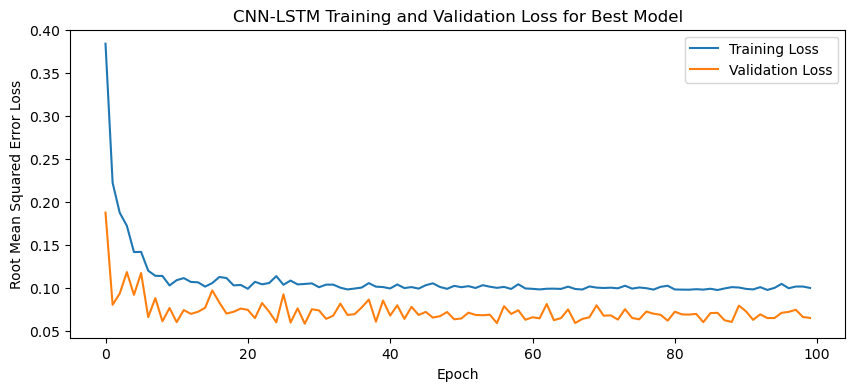

1/1 - 6s - loss: 0.1452 - 6s/epoch - 6s/step
Test Loss: 0.1452462524175644
Fold 2:
Epoch 1/100
19/19 [==============================] - 26s 394ms/step - loss: 0.3588 - val_loss: 0.1227
Epoch 2/100
19/19 [==============================] - 3s 145ms/step - loss: 0.1824 - val_loss: 0.1695
Epoch 3/100
19/19 [==============================] - 3s 139ms/step - loss: 0.1883 - val_loss: 0.2274
Epoch 4/100
19/19 [==============================] - 3s 132ms/step - loss: 0.2103 - val_loss: 0.1813
Epoch 5/100
19/19 [==============================] - 3s 177ms/step - loss: 0.1421 - val_loss: 0.1901
Epoch 6/100
19/19 [==============================] - 3s 137ms/step - loss: 0.1621 - val_loss: 0.1252
Epoch 7/100
19/19 [==============================] - 3s 146ms/step - loss: 0.1173 - val_loss: 0.0795
Epoch 8/100
19/19 [==============================] - 3s 132ms/step - loss: 0.0944 - val_loss: 0.1253
Epoch 9/100
19/19 [==============================] - 4s 197ms/step - loss: 0.1014 - val_loss: 0.0838
Epoch 1

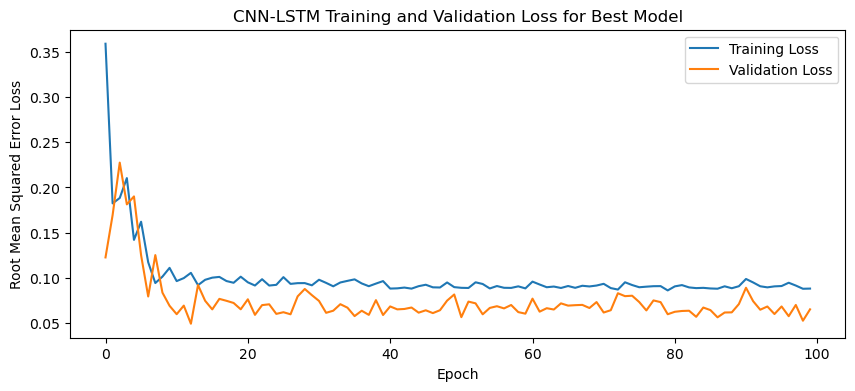

1/1 - 4s - loss: 0.0878 - 4s/epoch - 4s/step
Test Loss: 0.08780111372470856
Fold 3:
Epoch 1/100
19/19 [==============================] - 21s 372ms/step - loss: 0.3658 - val_loss: 0.0898
Epoch 2/100
19/19 [==============================] - 3s 172ms/step - loss: 0.2320 - val_loss: 0.0973
Epoch 3/100
19/19 [==============================] - 3s 134ms/step - loss: 0.1540 - val_loss: 0.1335
Epoch 4/100
19/19 [==============================] - 2s 104ms/step - loss: 0.1585 - val_loss: 0.0989
Epoch 5/100
19/19 [==============================] - 2s 91ms/step - loss: 0.1450 - val_loss: 0.0814
Epoch 6/100
19/19 [==============================] - 2s 104ms/step - loss: 0.1088 - val_loss: 0.0679
Epoch 7/100
19/19 [==============================] - 2s 109ms/step - loss: 0.1025 - val_loss: 0.0930
Epoch 8/100
19/19 [==============================] - 2s 126ms/step - loss: 0.1098 - val_loss: 0.0848
Epoch 9/100
19/19 [==============================] - 2s 127ms/step - loss: 0.1022 - val_loss: 0.0751
Epoch 1

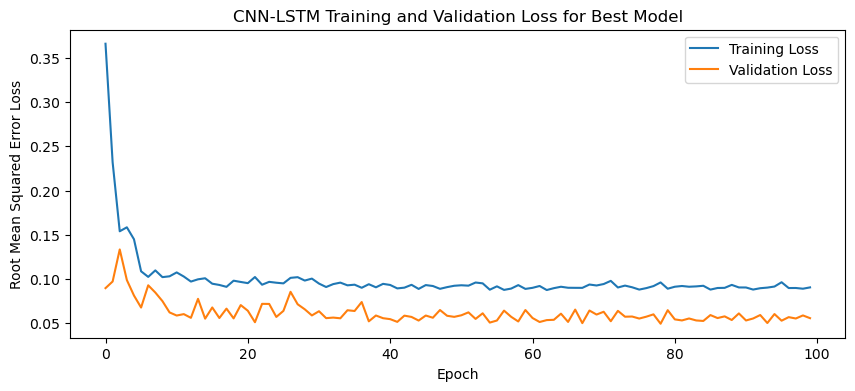

1/1 - 5s - loss: 0.1085 - 5s/epoch - 5s/step
Test Loss: 0.10847873240709305
Fold 4:
Epoch 1/100
20/20 [==============================] - 23s 362ms/step - loss: 0.3973 - val_loss: 0.1724
Epoch 2/100
20/20 [==============================] - 2s 121ms/step - loss: 0.2371 - val_loss: 0.2194
Epoch 3/100
20/20 [==============================] - 3s 169ms/step - loss: 0.1825 - val_loss: 0.3818
Epoch 4/100
20/20 [==============================] - 3s 166ms/step - loss: 0.1536 - val_loss: 0.1563
Epoch 5/100
20/20 [==============================] - 2s 97ms/step - loss: 0.1242 - val_loss: 0.0985
Epoch 6/100
20/20 [==============================] - 2s 111ms/step - loss: 0.1122 - val_loss: 0.1153
Epoch 7/100
20/20 [==============================] - 3s 143ms/step - loss: 0.0995 - val_loss: 0.1331
Epoch 8/100
20/20 [==============================] - 2s 107ms/step - loss: 0.0900 - val_loss: 0.1313
Epoch 9/100
20/20 [==============================] - 2s 115ms/step - loss: 0.1025 - val_loss: 0.1657
Epoch 1

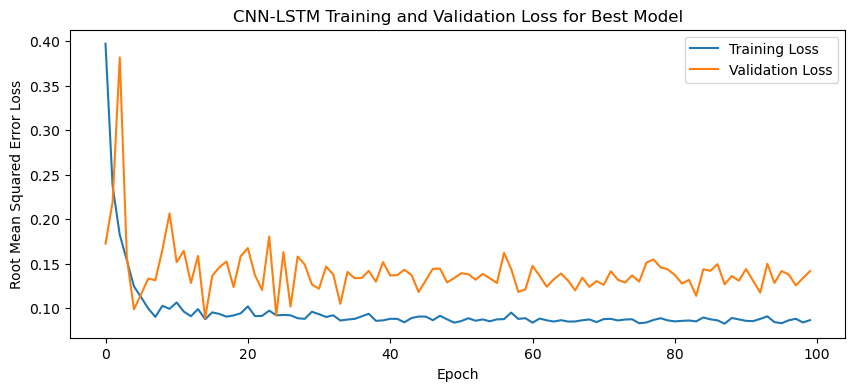

1/1 - 4s - loss: 0.0818 - 4s/epoch - 4s/step
Test Loss: 0.08181631565093994
Fold 5:
Epoch 1/100
19/19 [==============================] - 25s 471ms/step - loss: 0.4027 - val_loss: 0.1335
Epoch 2/100
19/19 [==============================] - 4s 223ms/step - loss: 0.2157 - val_loss: 0.2089
Epoch 3/100
19/19 [==============================] - 4s 185ms/step - loss: 0.1713 - val_loss: 0.1622
Epoch 4/100
19/19 [==============================] - 3s 172ms/step - loss: 0.1425 - val_loss: 0.0669
Epoch 5/100
19/19 [==============================] - 4s 186ms/step - loss: 0.1358 - val_loss: 0.2059
Epoch 6/100
19/19 [==============================] - 4s 211ms/step - loss: 0.1409 - val_loss: 0.1759
Epoch 7/100
19/19 [==============================] - 4s 175ms/step - loss: 0.1246 - val_loss: 0.1471
Epoch 8/100
19/19 [==============================] - 2s 130ms/step - loss: 0.0955 - val_loss: 0.0927
Epoch 9/100
19/19 [==============================] - 3s 131ms/step - loss: 0.0853 - val_loss: 0.1617
Epoch 

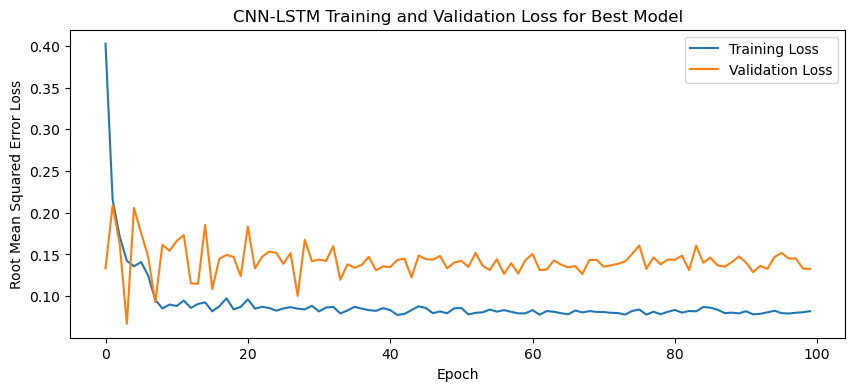

1/1 - 5s - loss: 0.0620 - 5s/epoch - 5s/step
Test Loss: 0.06203361973166466


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

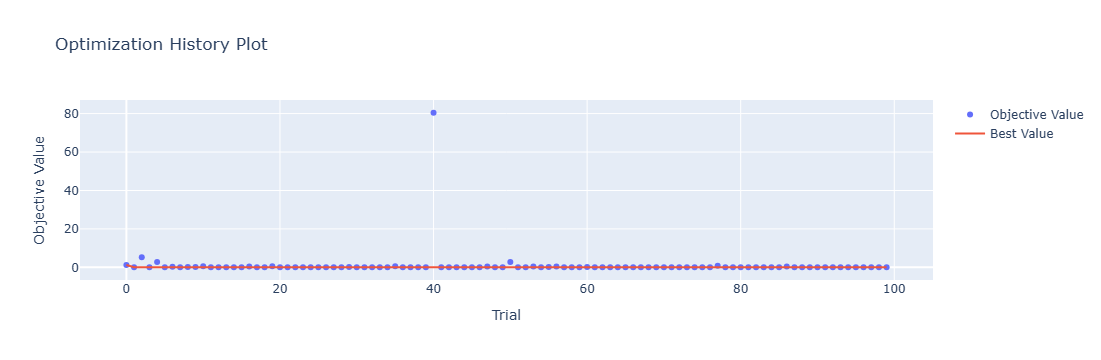

In [4]:
optuna.visualization.plot_optimization_history(study)

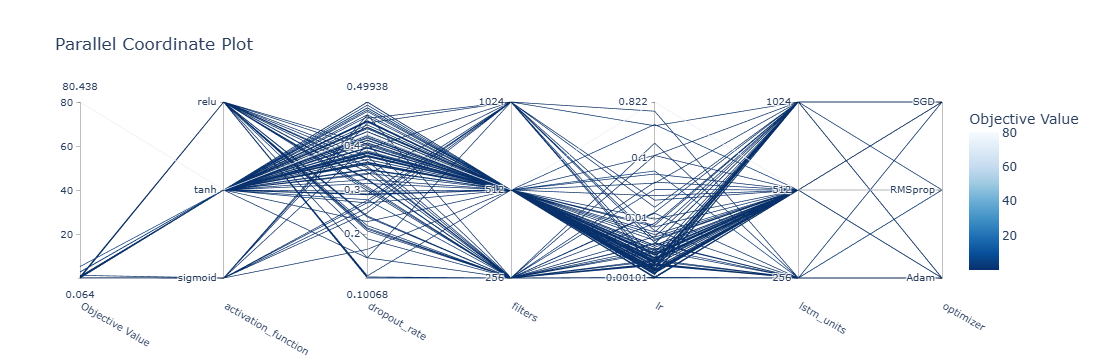

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

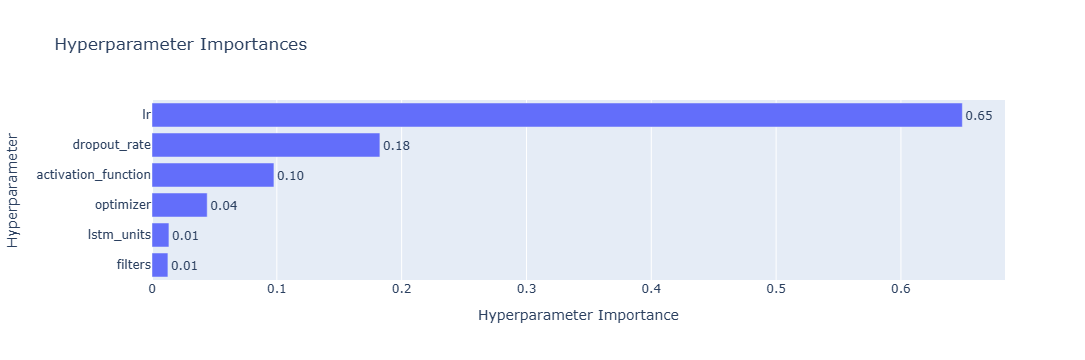

In [6]:
optuna.visualization.plot_param_importances(study)

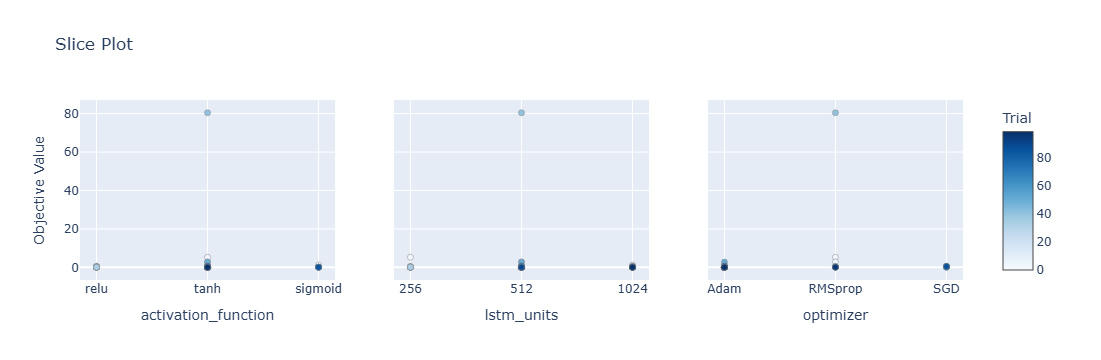

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

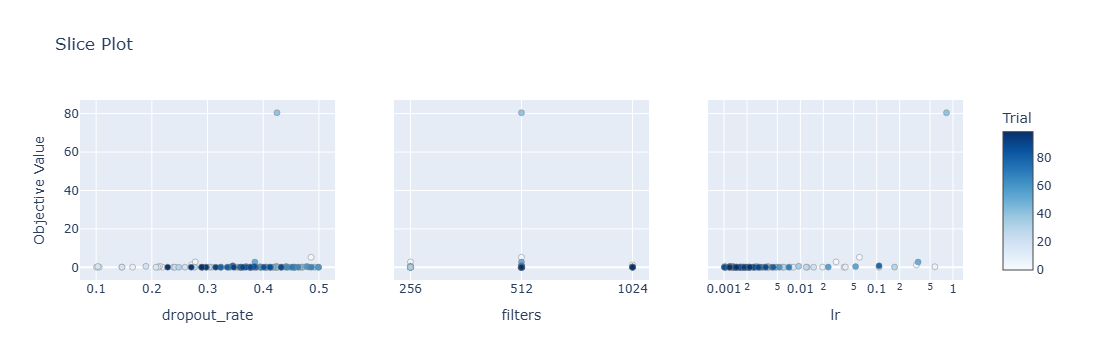

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 19s 284ms/step - loss: 0.2854 - accuracy: 0.4737 - mae: 0.2495 - rmse: 0.2854 - mape: 43.9626 - pearson: 0.2936 - val_loss: 0.3139 - val_accuracy: 0.0000e+00 - val_mae: 0.2404 - val_rmse: 0.3139 - val_mape: 40.1613 - val_pearson: 0.1307
Epoch 2/100
19/19 [==============================] - 1s 75ms/step - loss: 0.2206 - accuracy: 0.4211 - mae: 0.1875 - rmse: 0.2206 - mape: 36.8288 - pearson: 0.2893 - val_loss: 0.1376 - val_accuracy: 0.3333 - val_mae: 0.1272 - val_rmse: 0.1376 - val_mape: 23.5166 - val_pearson: 0.1045
Epoch 3/100
19/19 [==============================] - 1s 58ms/step - loss: 0.1648 - accu

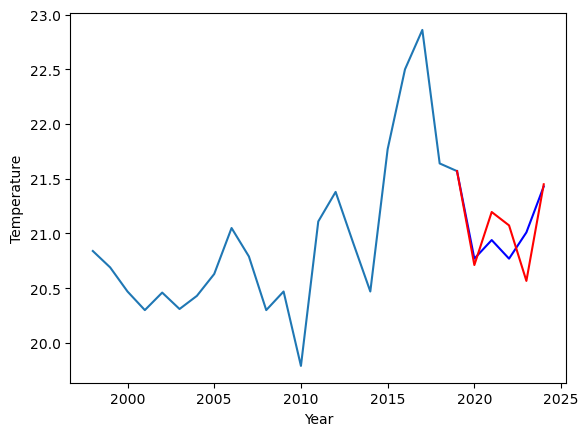

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		16.44		-1.08
16.69		16.93		0.24
16.18		16.80		0.62
16.46		16.30		-0.16
16.29		17.18		0.89


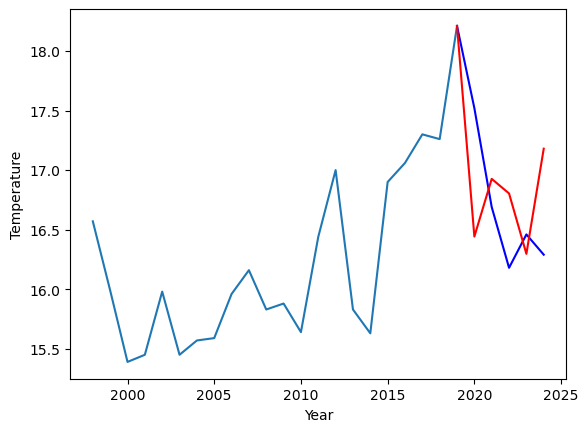

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  20.711847
1                1   17.52  16.441931


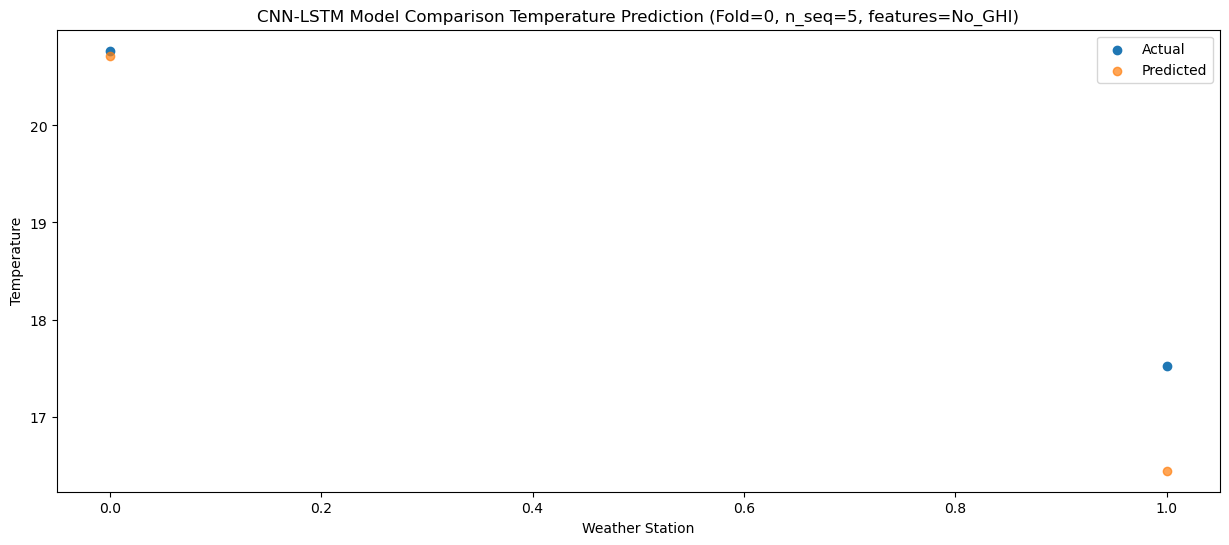

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  21.196244
1                1   16.69  16.926288


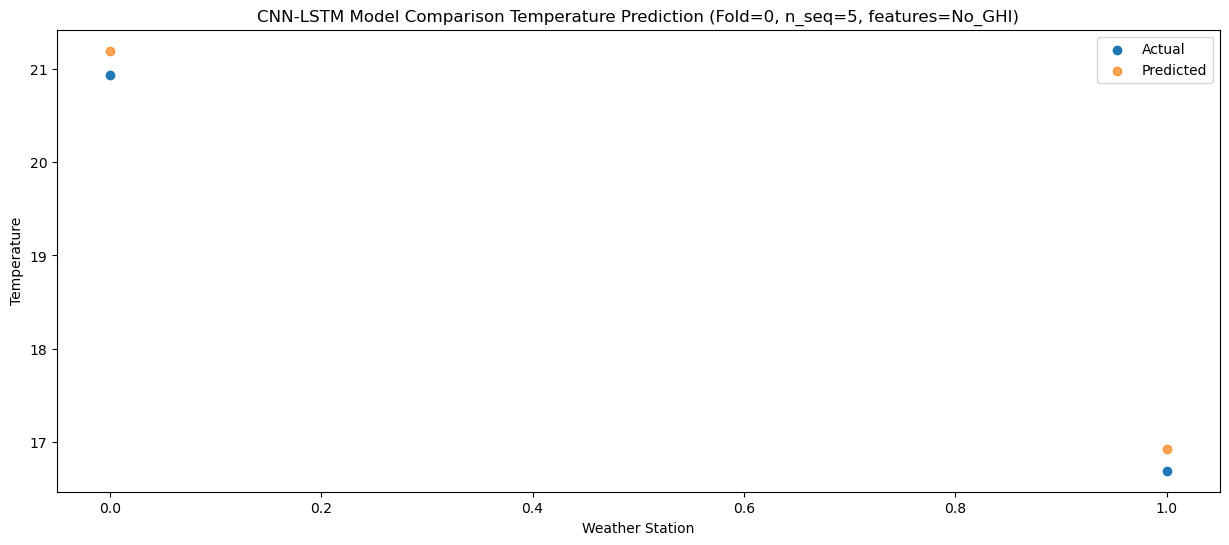

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  21.073981
1                1   16.18  16.804007


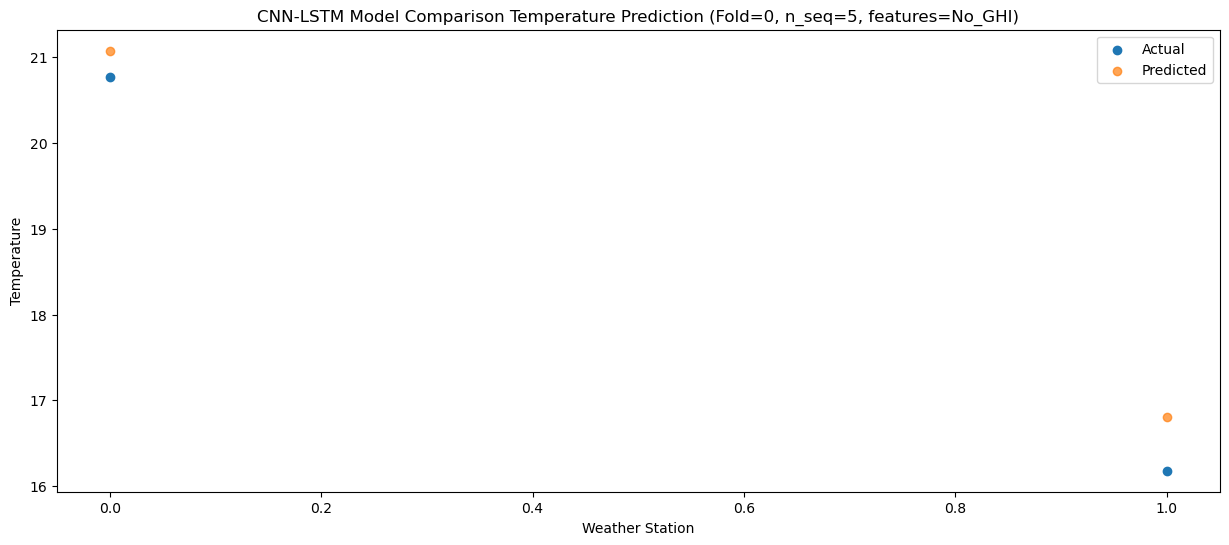

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  20.566872
1                1   16.46  16.297029


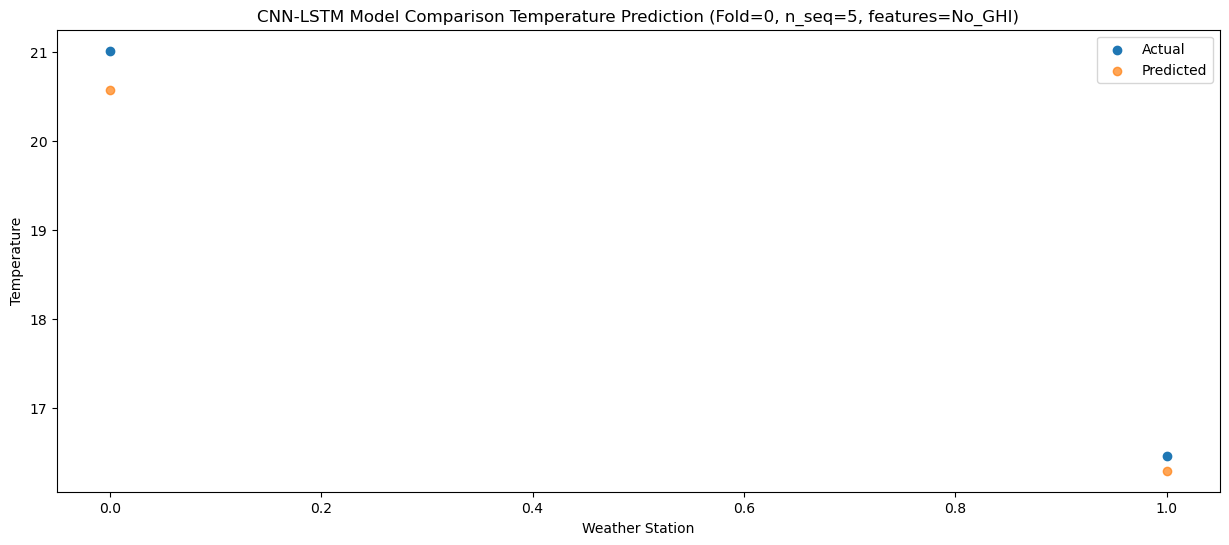

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  21.449537
1                1   16.29  17.179605


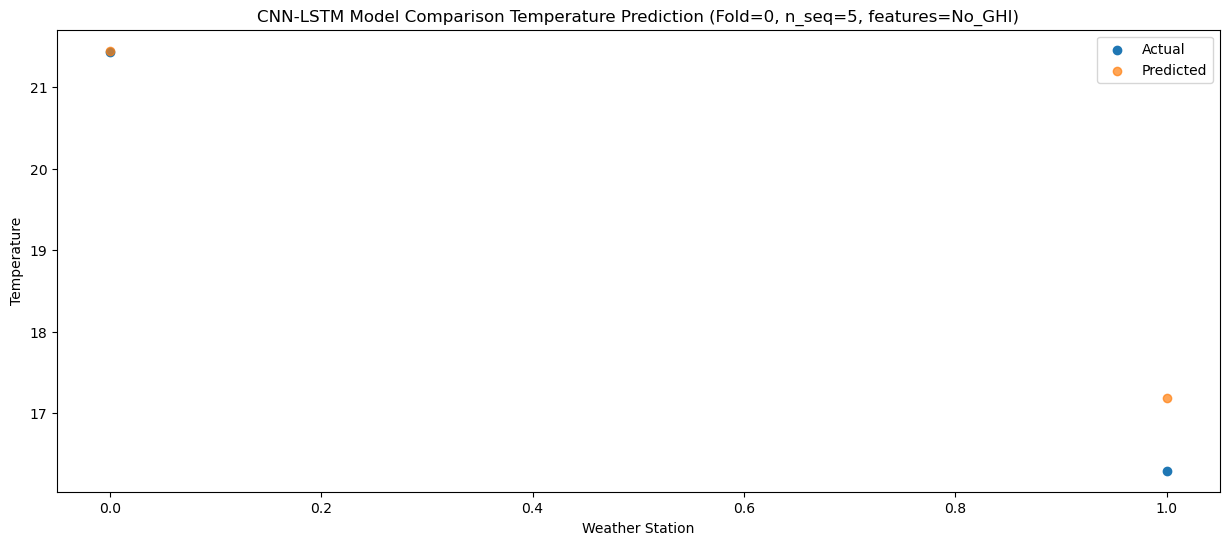

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[20.71184687 16.44193114]
 [21.19624398 16.92628849]
 [21.0739806  16.80400723]
 [20.56687244 16.2970289 ]
 [21.44953718 17.17960465]]
Year at t+1:
t+1 SKRMSE: 0.763418
t+1 KRMSE: 0.763418
t+1 MAE: 0.568111
t+1 SKMAPE: 0.032167
t+1 R2_SCORE: 0.779292
t+1 KMAPE: 0.032167
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.246468
t+2 KRMSE: 0.246468
t+2 MAE: 0.246266
t+2 SKMAPE: 0.013197
t+2 R2_SCORE: 0.986547
t+2 KMAPE: 0.013197
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.490810
t+3 KRMSE: 0.490810
t+3 MAE: 0.463994
t+3 SKMAPE: 0.026601
t+3 R2_SCORE: 0.954264
t+3 KMAPE: 0.026601
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.333857
t+4 KRMSE: 0.333857
t+4 MAE: 0.303049
t+4 SKMAPE: 0.015496
t+4 R2_SCORE: 0.978464
t+4 KMAPE: 0.015496
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.629197
t+5 KRMSE: 0.629197
t+5 MAE: 0.454571
t+5 SKMAPE: 0.027761
t+5 R2_SCORE: 0.940061
t+5 KMAPE: 0.027761
t+5 PEARSON: 1

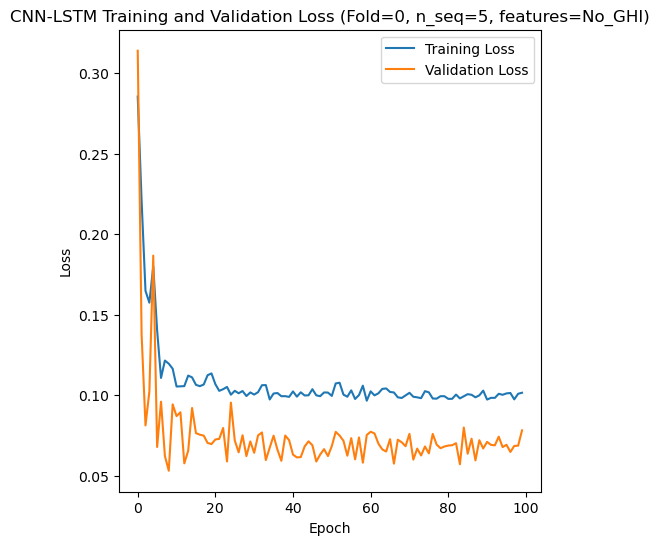

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 20s 320ms/step - loss: 0.2807 - accuracy: 0.2105 - mae: 0.2464 - rmse: 0.2807 - mape: 41.1823 - pearson: 0.2758 - val_loss: 0.1573 - val_accuracy: 1.0000 - val_mae: 0.1085 - val_rmse: 0.1573 - val_mape: 16.7340 - val_pearson: 0.3470
Epoch 2/100
19/19 [==============================] - 2s 112ms/step - loss: 0.2044 - accuracy: 0.3158 - mae: 0.1769 - rmse: 0.2044 - mape: 29.4452 - pearson: 0.2759 - val_loss: 0.1946 - val_accuracy: 1.0000 - val_mae: 0.1454 - val_rmse: 0.1946 - val_mape: 22.2658 - val_pearson: 0.2813
Epoch 3/100
19/19 [==============================] - 2s 129ms/step - loss: 0.2050 - accurac

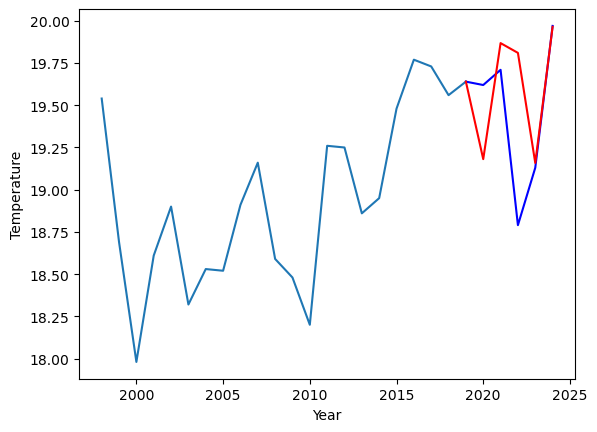

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		19.33		-0.49
20.34		20.02		-0.32
19.95		19.96		0.01
19.95		19.31		-0.64
21.26		20.11		-1.15


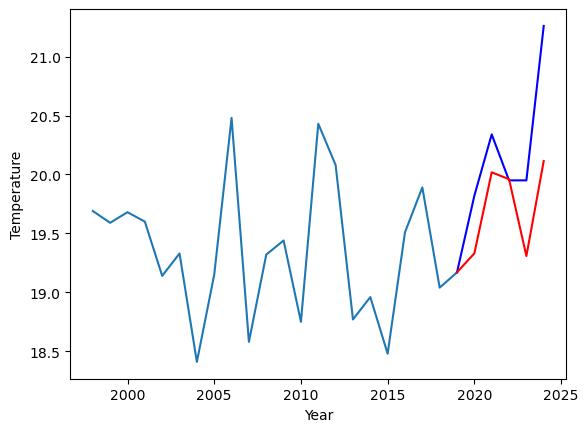

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  19.180943
1                1   19.82  19.330914


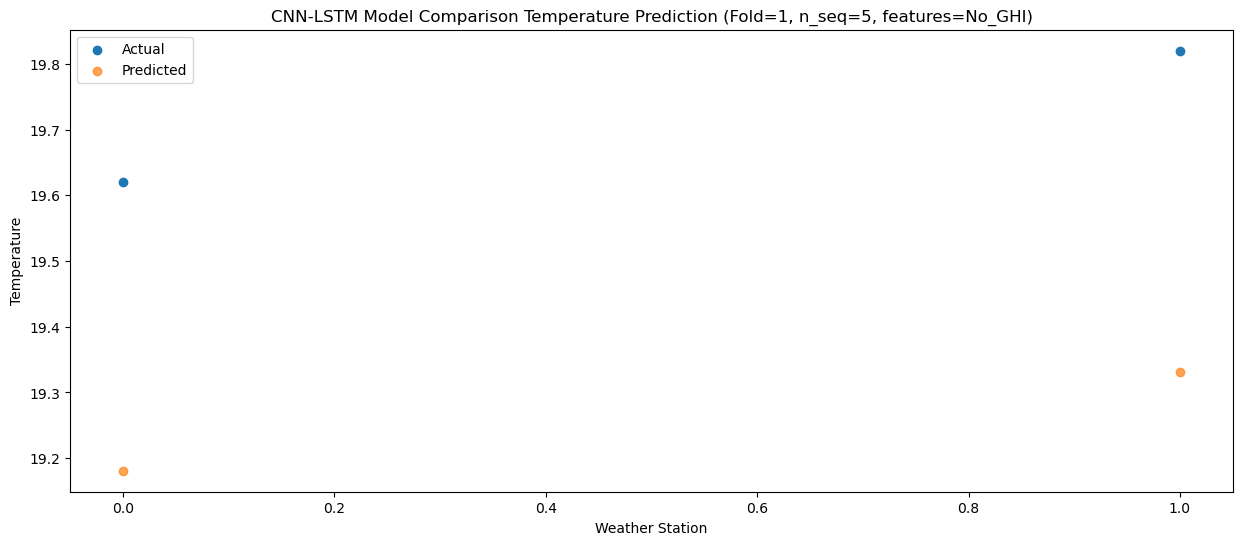

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  19.868238
1                1   20.34  20.018201


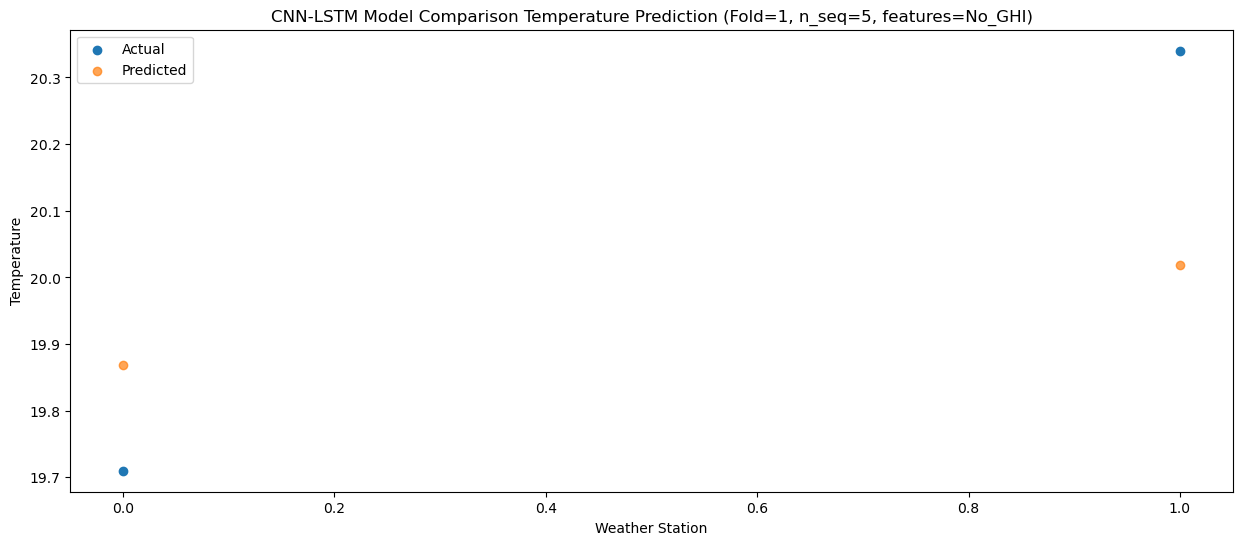

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  19.810326
1                1   19.95  19.960149


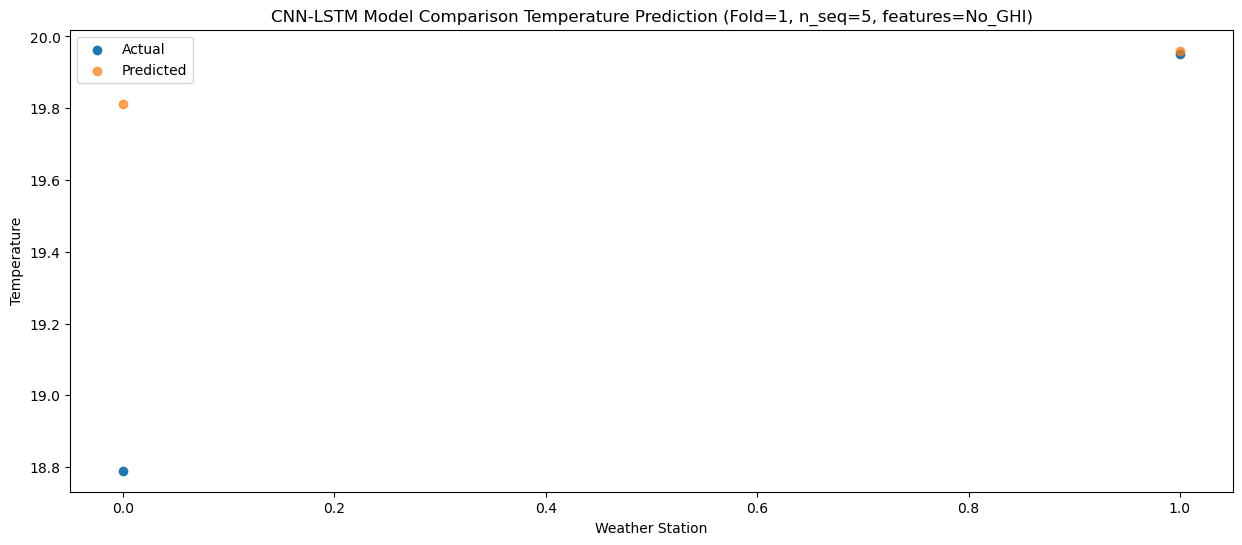

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.158502
1                1   19.95  19.308241


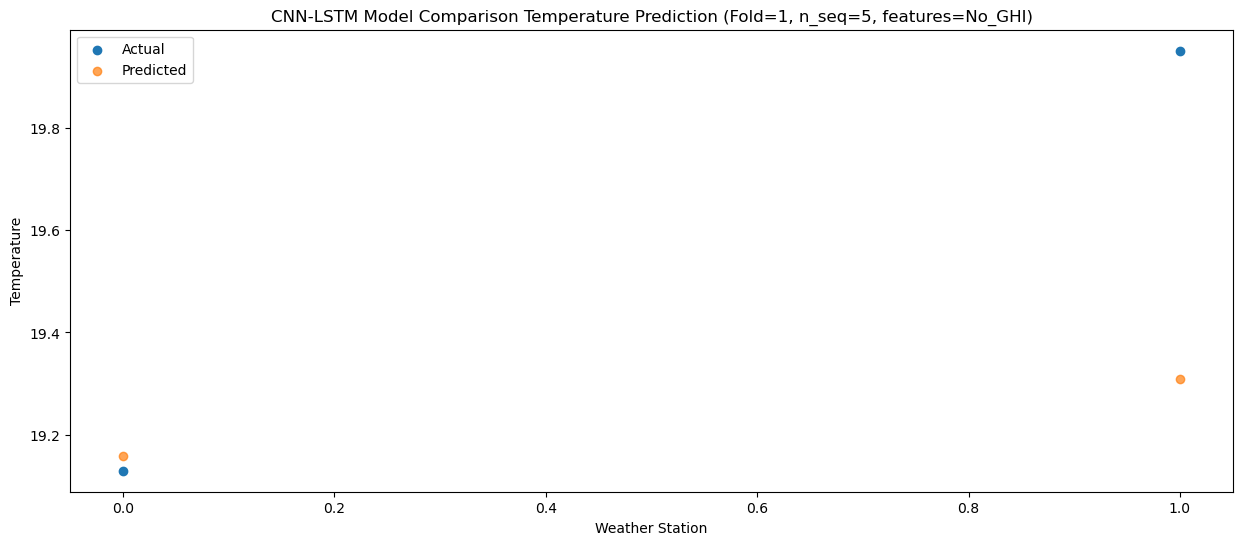

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  19.964604
1                1   21.26  20.114270


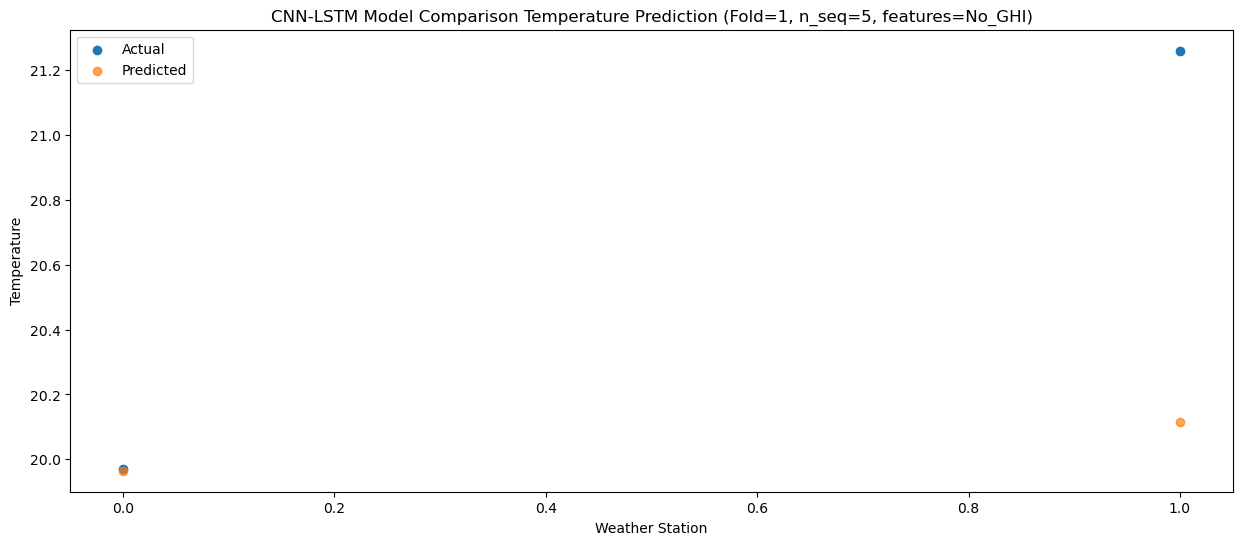

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[19.18094257 19.33091361]
 [19.86823843 20.01820064]
 [19.81032564 19.96014896]
 [19.15850248 19.30824103]
 [19.96460398 20.11426994]]
Year at t+1:
t+1 SKRMSE: 0.464746
t+1 KRMSE: 0.464746
t+1 MAE: 0.464072
t+1 SKMAPE: 0.023527
t+1 R2_SCORE: -20.598846
t+1 KMAPE: 0.023527
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.253569
t+2 KRMSE: 0.253569
t+2 MAE: 0.240019
t+2 SKMAPE: 0.011925
t+2 R2_SCORE: 0.352007
t+2 KMAPE: 0.011925
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.721515
t+3 KRMSE: 0.721515
t+3 MAE: 0.515237
t+3 SKMAPE: 0.027405
t+3 R2_SCORE: -0.547514
t+3 KMAPE: 0.027405
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.454239
t+4 KRMSE: 0.454239
t+4 MAE: 0.335131
t+4 SKMAPE: 0.016829
t+4 R2_SCORE: -0.227445
t+4 KMAPE: 0.016829
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.810162
t+5 KRMSE: 0.810162
t+5 MAE: 0.575563
t+5 SKMAPE: 0.027081
t+5 R2_SCORE: -0.577701
t+5 KMAPE: 0.027081
t+5 PEARS

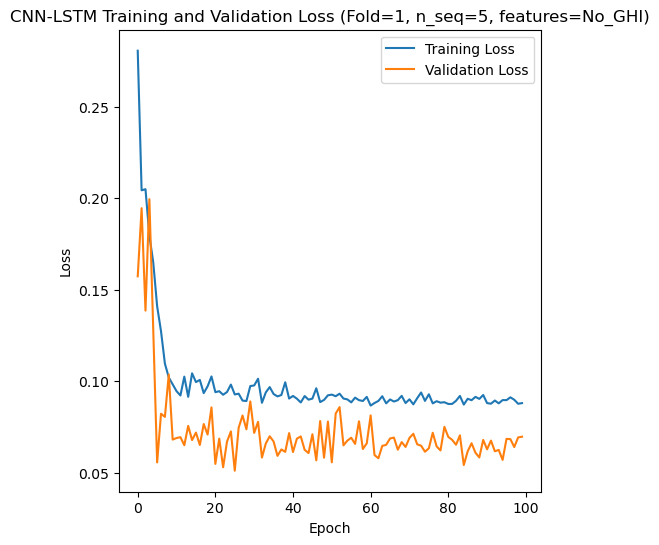

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 23s 258ms/step - loss: 0.3285 - accuracy: 0.2632 - mae: 0.2898 - rmse: 0.3285 - mape: 45.8497 - pearson: 0.3764 - val_loss: 0.2080 - val_accuracy: 0.0000e+00 - val_mae: 0.1707 - val_rmse: 0.2080 - val_mape: 28.2379 - val_pearson: 0.1642
Epoch 2/100
19/19 [==============================] - 1s 47ms/step - loss: 0.2326 - accuracy: 0.3684 - mae: 0.2052 - rmse: 0.2326 - mape: 34.9156 - pearson: 0.3850 - val_loss: 0.2451 - val_accuracy: 0.6667 - val_mae: 0.2298 - val_rmse: 0.2451 - val_mape: 36.8105 - val_pearson: 0.5396
Epoch 3/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1867 - accur

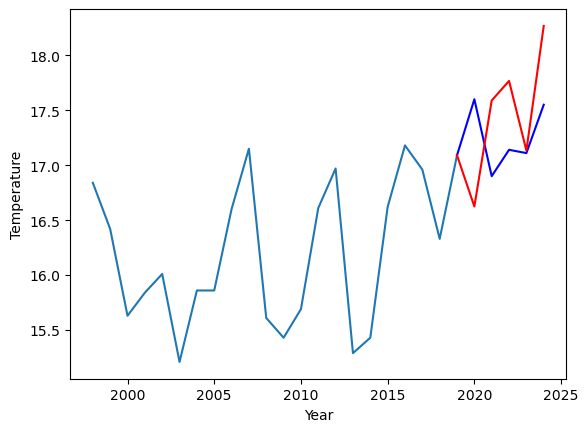

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		13.29		-0.55
13.83		14.26		0.43
13.82		14.44		0.62
13.36		13.80		0.44
14.15		14.94		0.79


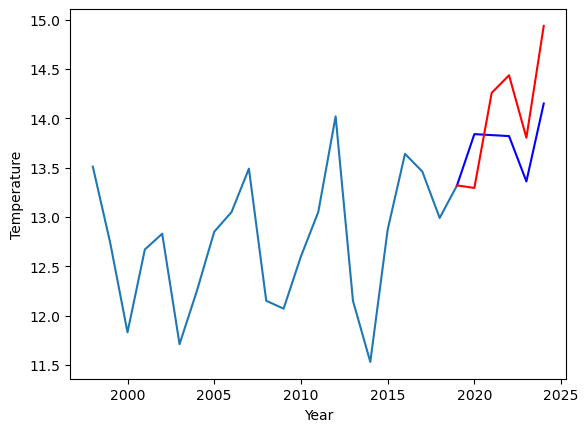

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  16.624157
1                1   13.84  13.294157


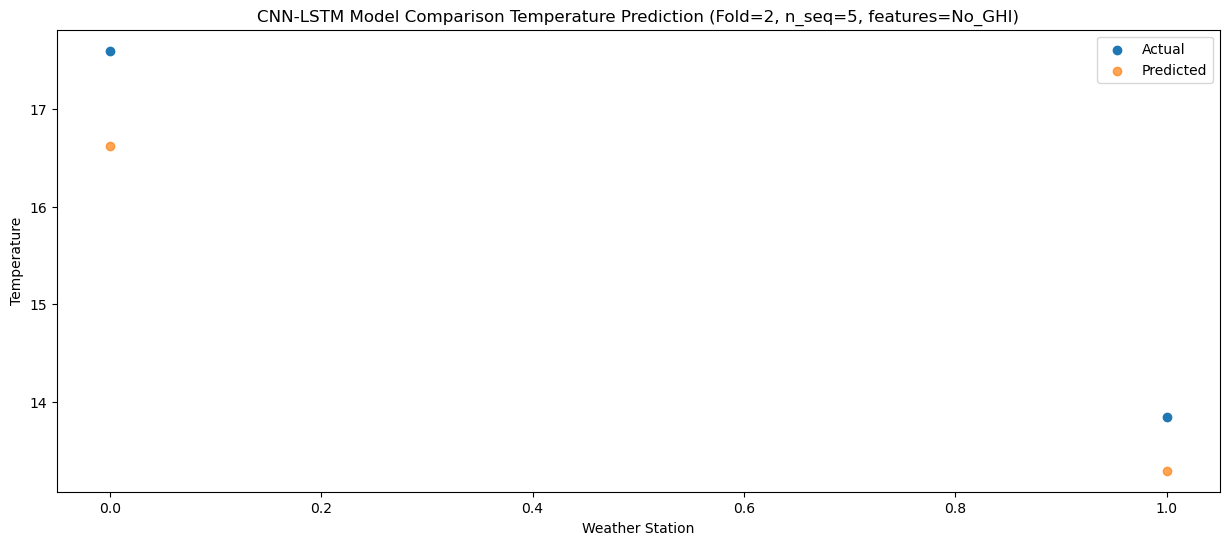

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.588658
1                1   13.83  14.258658


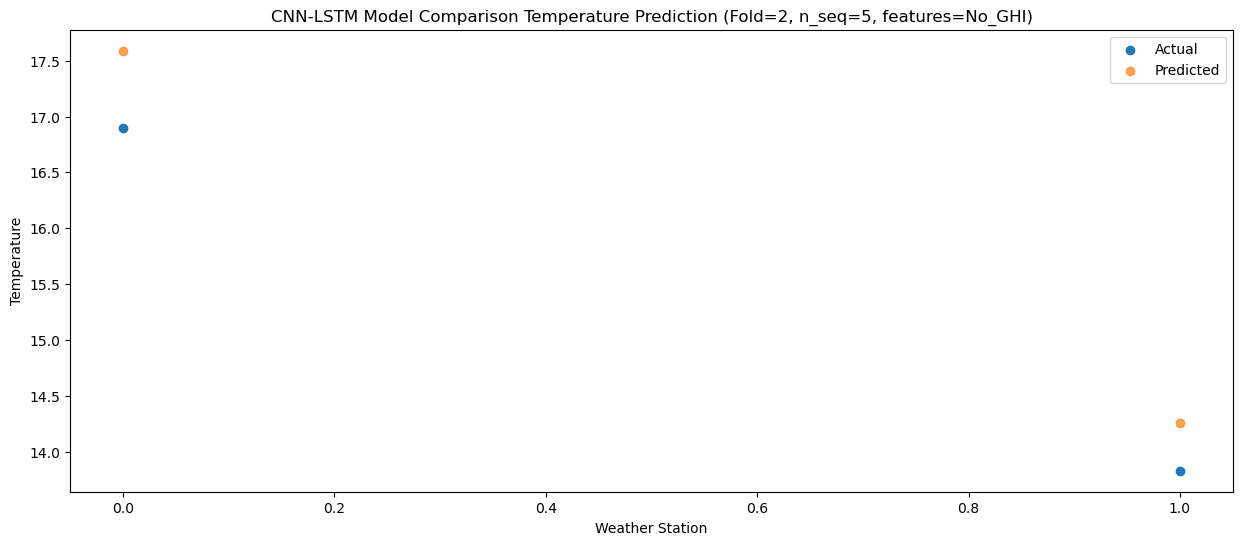

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  17.766636
1                1   13.82  14.436636


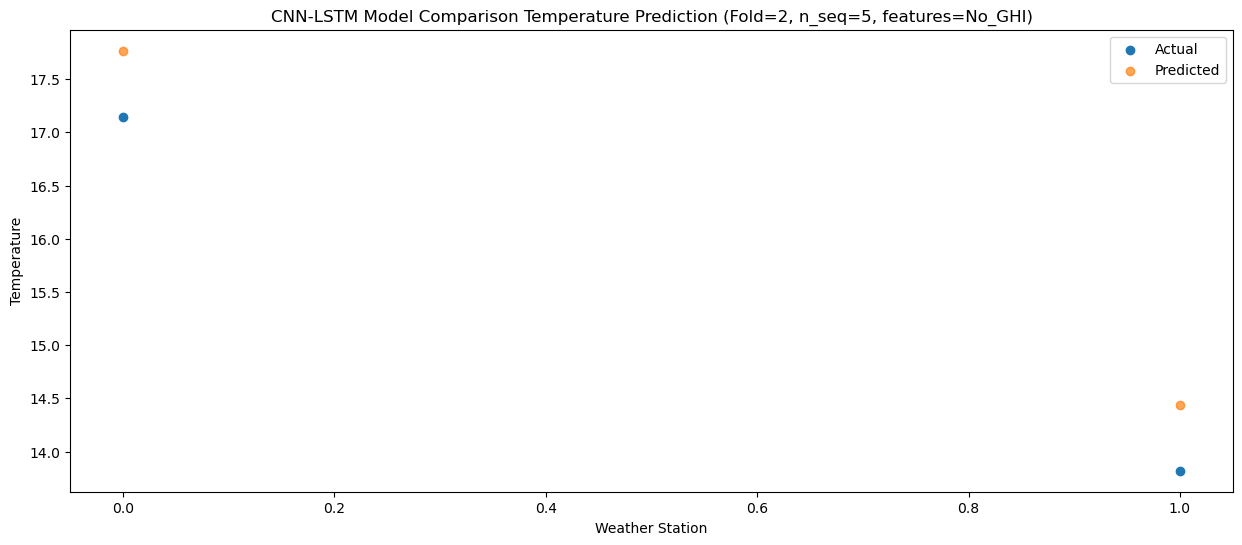

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  17.133159
1                1   13.36  13.803159


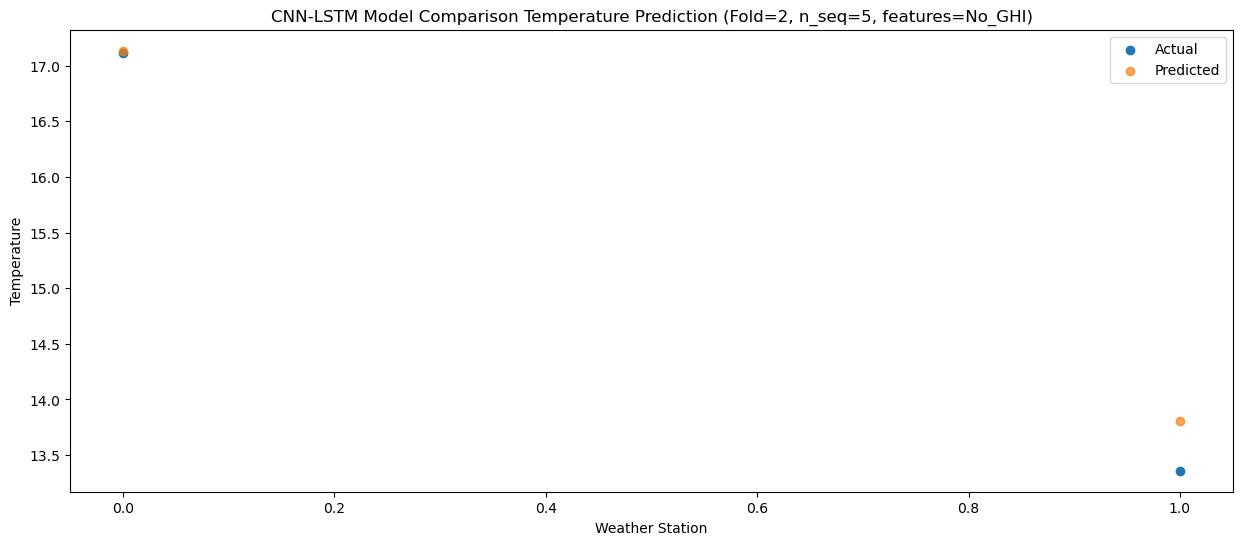

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55   18.26714
1                1   14.15   14.93714


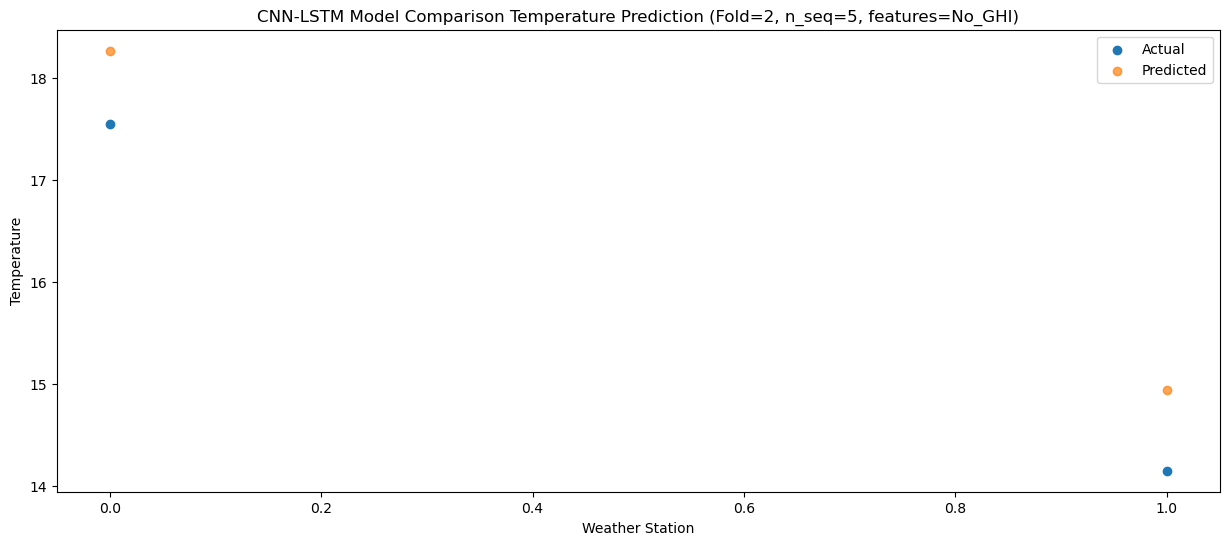

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[16.6241565  13.2941565 ]
 [17.5886583  14.2586583 ]
 [17.7666364  14.4366364 ]
 [17.13315931 13.80315931]
 [18.2671397  14.9371397 ]]
Year at t+1:
t+1 SKRMSE: 0.790638
t+1 KRMSE: 0.790638
t+1 MAE: 0.760843
t+1 SKMAPE: 0.047443
t+1 R2_SCORE: 0.823136
t+1 KMAPE: 0.047443
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.573584
t+2 KRMSE: 0.573584
t+2 MAE: 0.558658
t+2 SKMAPE: 0.035872
t+2 R2_SCORE: 0.860370
t+2 KMAPE: 0.035872
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.621657
t+3 KRMSE: 0.621657
t+3 MAE: 0.621636
t+3 SKMAPE: 0.040590
t+3 R2_SCORE: 0.859756
t+3 KMAPE: 0.040590
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.313789
t+4 KRMSE: 0.313789
t+4 MAE: 0.233159
t+4 SKMAPE: 0.017262
t+4 R2_SCORE: 0.971993
t+4 KMAPE: 0.017262
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.752954
t+5 KRMSE: 0.752954
t+5 MAE: 0.752140
t+5 SKMAPE: 0.048245
t+5 R2_SCORE: 0.803827
t+5 KMAPE: 0.048245
t+5 PEARSON: 1

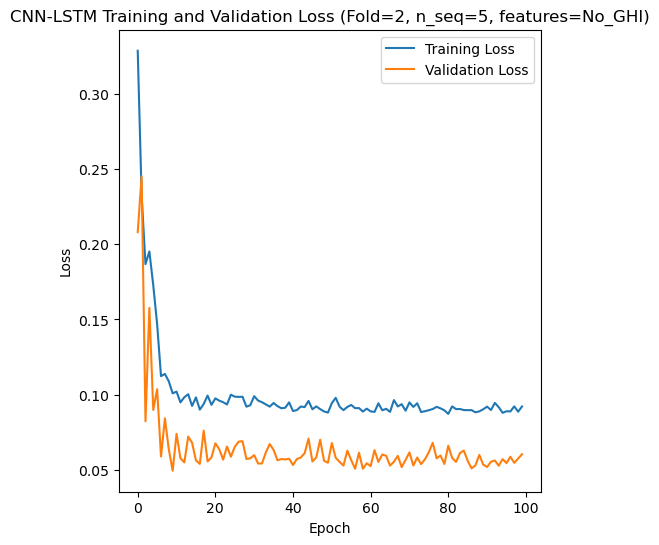

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 31s 455ms/step - loss: 0.3648 - accuracy: 0.4000 - mae: 0.3289 - rmse: 0.3648 - mape: 52.8903 - pearson: 0.3408 - val_loss: 0.2280 - val_accuracy: 0.5000 - val_mae: 0.1664 - val_rmse: 0.2280 - val_mape: 23.3149 - val_pearson: 0.1383
Epoch 2/100
20/20 [==============================] - 1s 72ms/step - loss: 0.2079 - accuracy: 0.2500 - mae: 0.1684 - rmse: 0.2079 - mape: 25.9867 - pearson: 0.2358 - val_loss: 0.1173 - val_accuracy: 0.5000 - val_mae: 0.1053 - val_rmse: 0.1173 - val_mape: 19.3307 - val_pearson: 0.6913
Epoch 3/100
20/20 [==============================] - 1s 51ms/step - loss: 0.1911 - accuracy: 

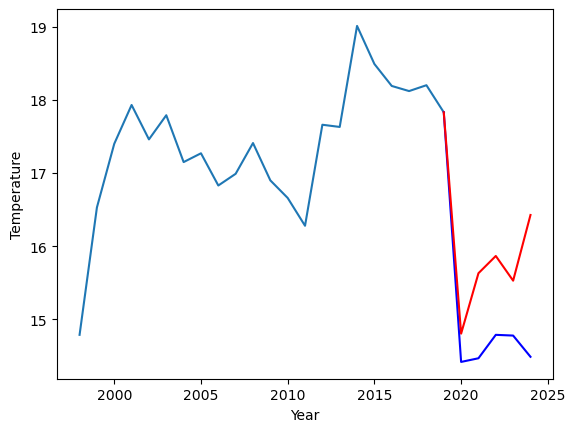

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		14.08		-0.39
14.35		14.90		0.55
14.15		15.14		0.99
13.85		14.80		0.95
14.87		15.70		0.83


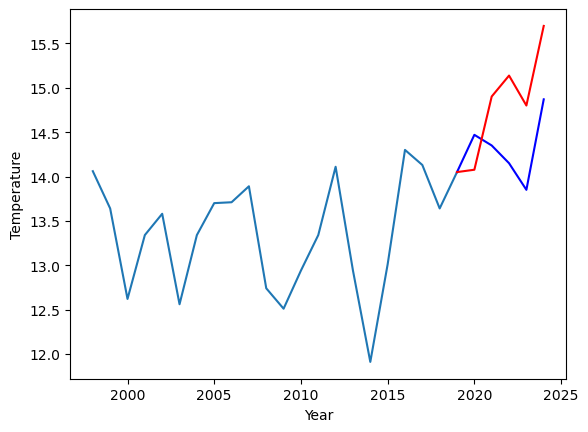

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.806194
1                1   14.47  14.076462


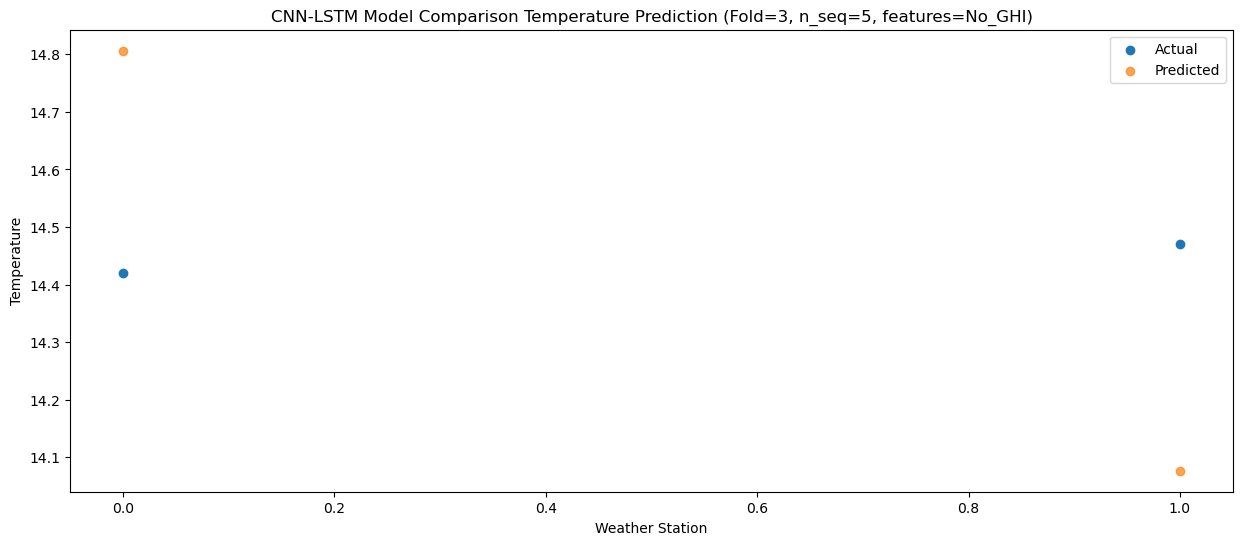

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.631641
1                1   14.35  14.901976


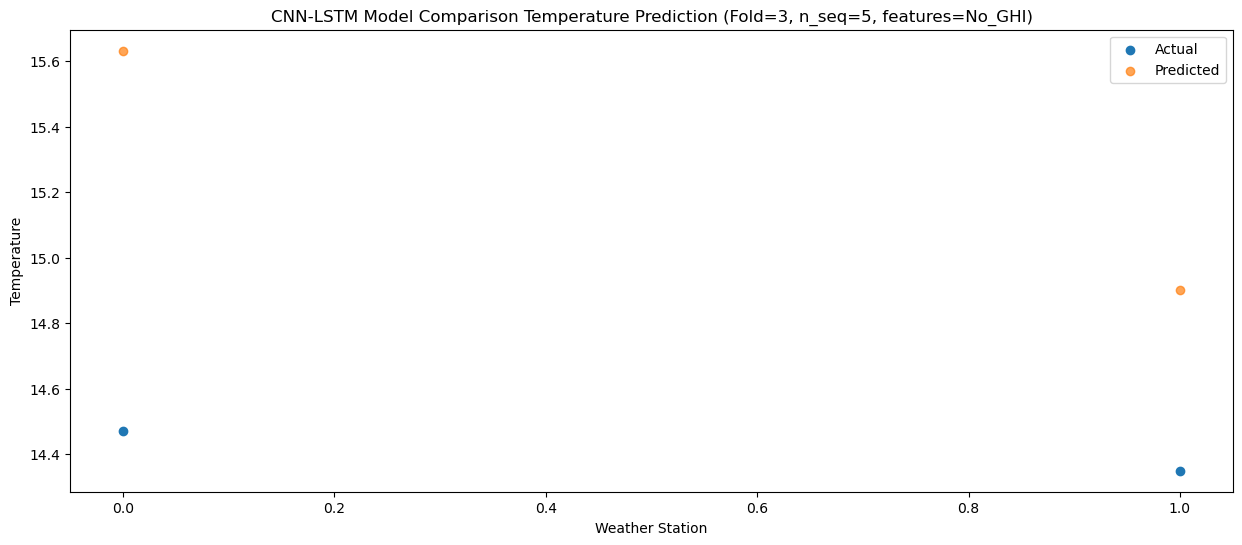

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  15.867371
1                1   14.15  15.137865


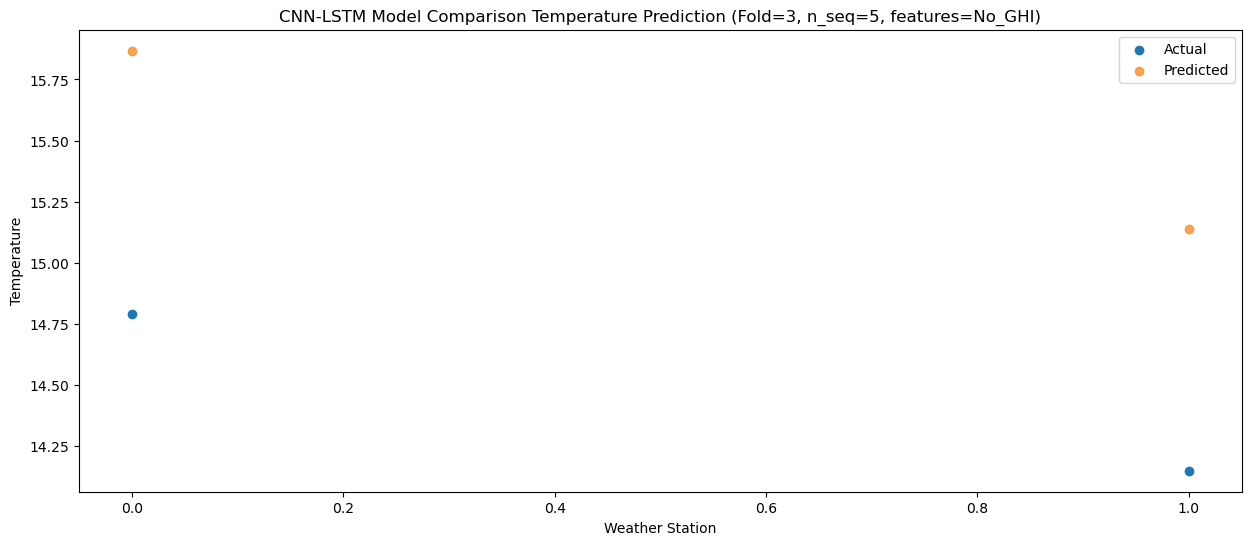

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  15.529901
1                1   13.85  14.800342


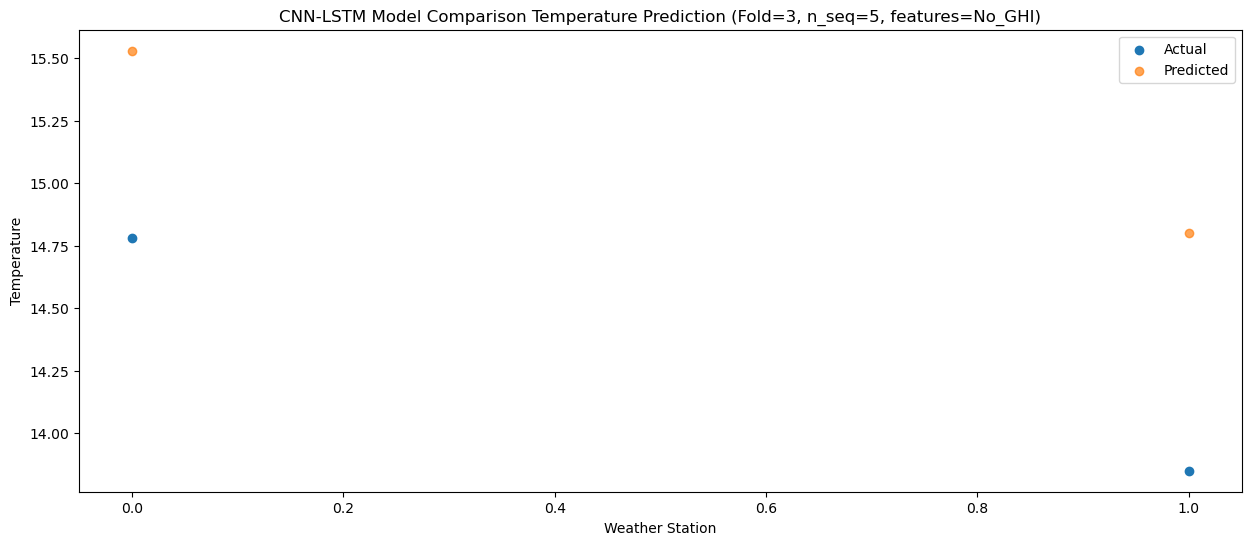

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  16.427241
1                1   14.87  15.697614


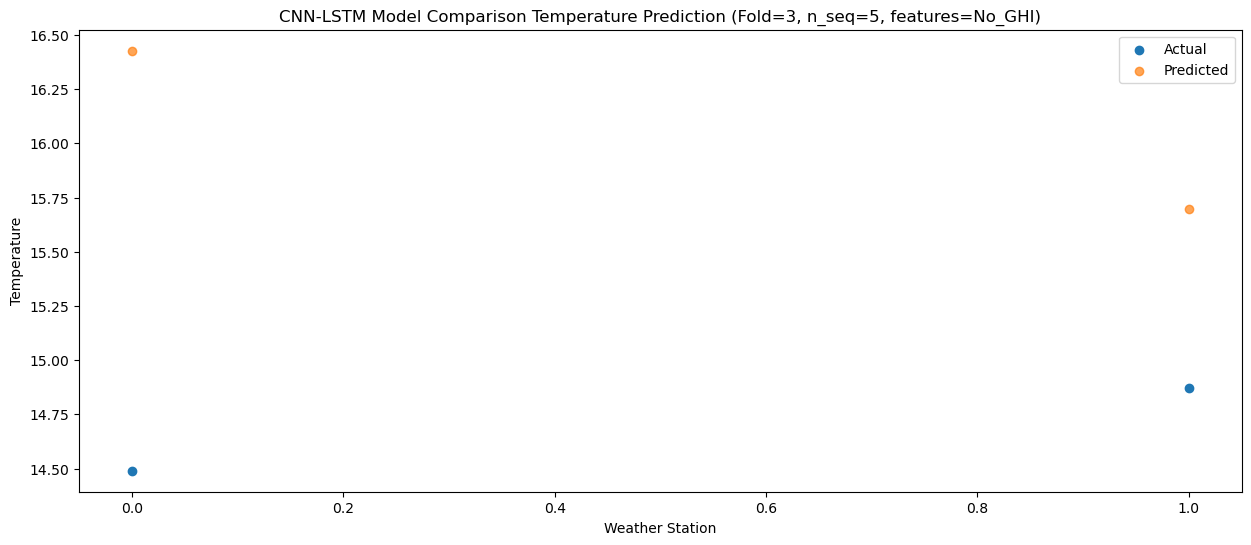

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.80619412 14.07646163]
 [15.63164067 14.90197624]
 [15.867371   15.13786545]
 [15.52990077 14.80034172]
 [16.42724107 15.69761395]]
Year at t+1:
t+1 SKRMSE: 0.389884
t+1 KRMSE: 0.389884
t+1 MAE: 0.389866
t+1 SKMAPE: 0.026989
t+1 R2_SCORE: -242.214680
t+1 KMAPE: 0.026989
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.909419
t+2 KRMSE: 0.909419
t+2 MAE: 0.856808
t+2 SKMAPE: 0.059372
t+2 R2_SCORE: -228.734279
t+2 KMAPE: 0.059372
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.033588
t+3 KRMSE: 1.033588
t+3 MAE: 1.032618
t+3 SKMAPE: 0.071329
t+3 R2_SCORE: -9.432649
t+3 KMAPE: 0.071329
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.856008
t+4 KRMSE: 0.856008
t+4 MAE: 0.850121
t+4 SKMAPE: 0.059677
t+4 R2_SCORE: -2.388832
t+4 KMAPE: 0.059677
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.489605
t+5 KRMSE: 1.489605
t+5 MAE: 1.382428
t+5 SKMAPE: 0.094676
t+5 R2_SCORE: -60.466036
t+5 KMAPE: 0.094676
t+5 

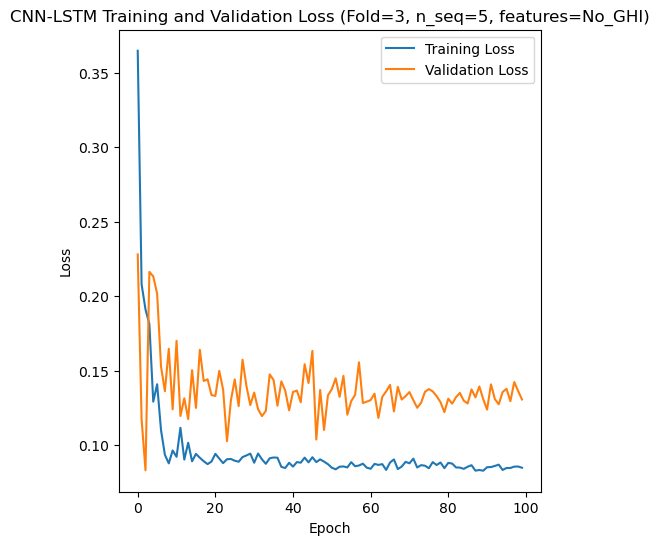

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 29s 381ms/step - loss: 0.2835 - accuracy: 0.3684 - mae: 0.2514 - rmse: 0.2835 - mape: 40.2143 - pearson: 0.3130 - val_loss: 0.1533 - val_accuracy: 1.0000 - val_mae: 0.1366 - val_rmse: 0.1533 - val_mape: 23.3053 - val_pearson: 0.4615
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.2205 - accuracy: 0.3158 - mae: 0.1889 - rmse: 0.2205 - mape: 29.5284 - pearson: 0.3567 - val_loss: 0.2887 - val_accuracy: 0.0000e+00 - val_mae: 0.2021 - val_rmse: 0.2887 - val_mape: 46.5839 - val_pearson: 0.1666
Epoch 3/100
19/19 [==============================] - 1s 48ms/step - loss: 0.1850 - accu

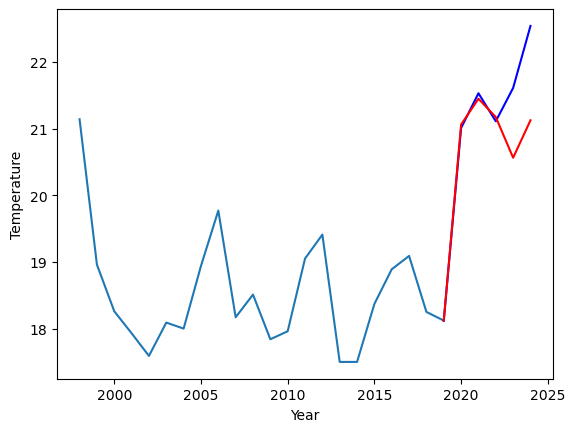

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		12.85		0.62
12.79		13.24		0.45
13.11		12.96		-0.15
12.24		12.35		0.11
13.72		12.91		-0.81


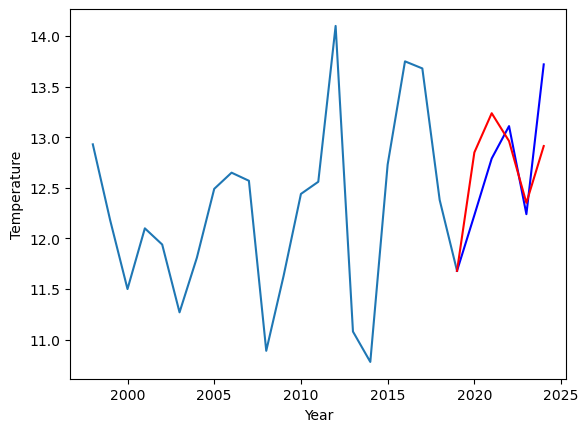

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  21.060169
1                1   12.23  12.849831


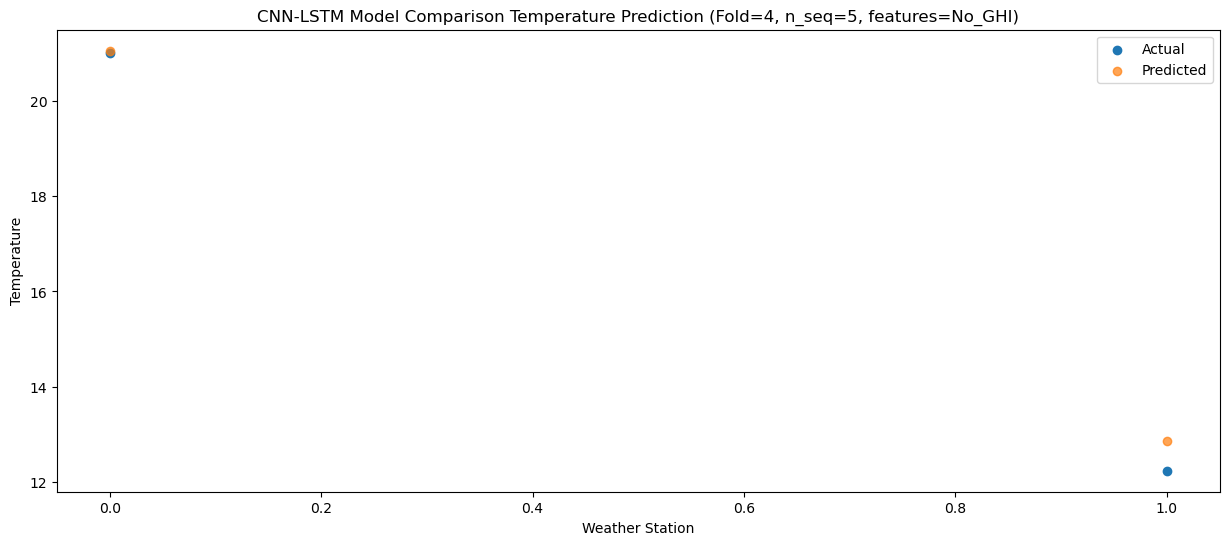

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  21.447769
1                1   12.79  13.237427


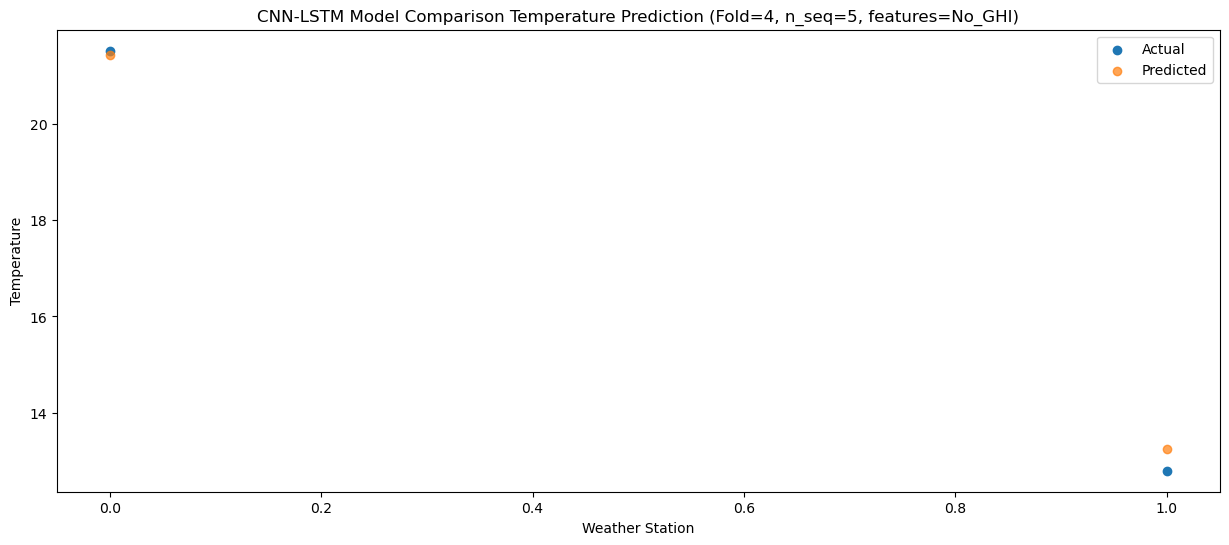

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  21.172946
1                1   13.11  12.962143


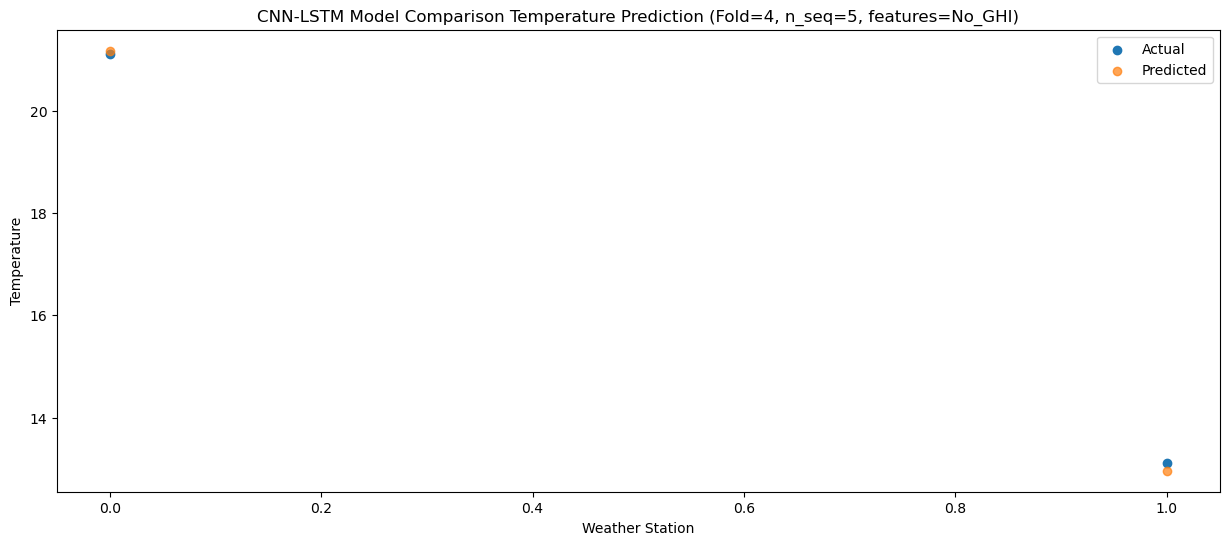

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  20.562950
1                1   12.24  12.351786


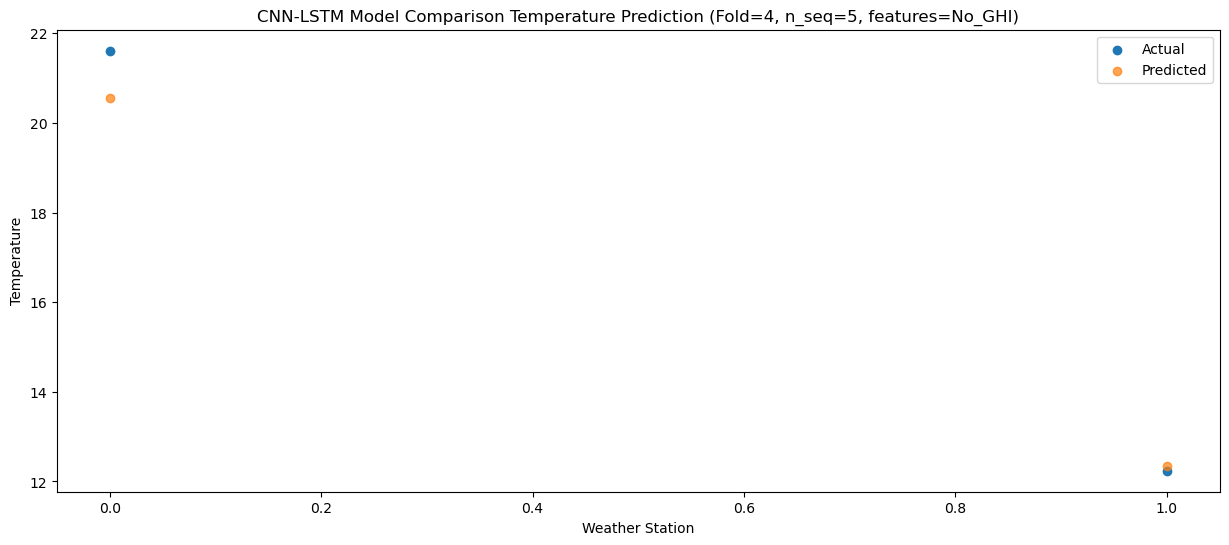

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  21.124497
1                1   13.72  12.913069


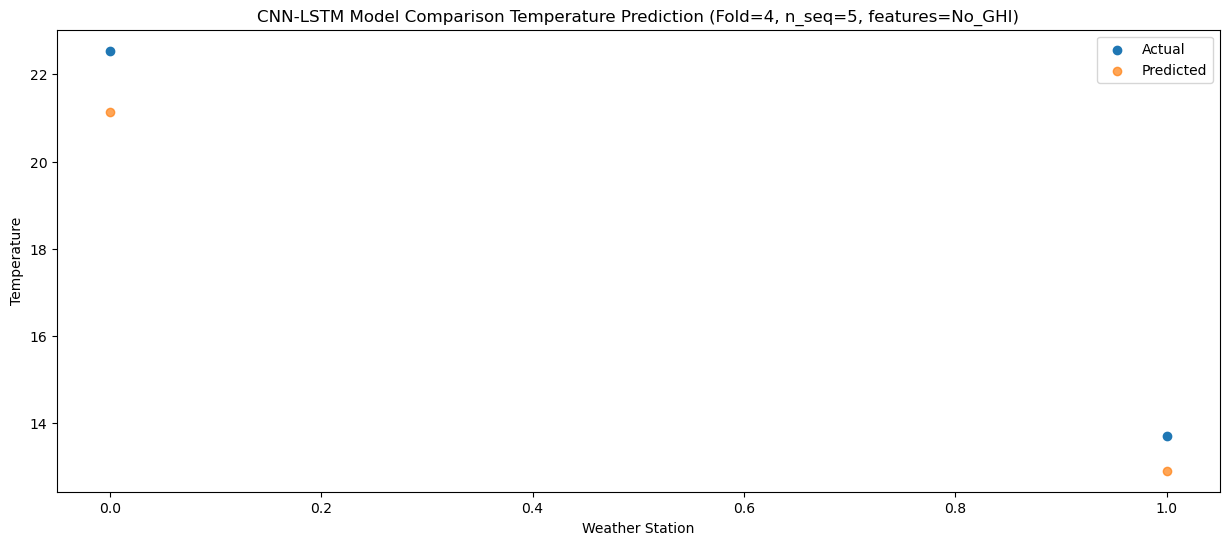

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[21.06016853 12.84983116]
 [21.44776866 13.23742667]
 [21.17294633 12.96214277]
 [20.56295019 12.35178614]
 [21.12449741 12.91306901]]
Year at t+1:
t+1 SKRMSE: 0.439720
t+1 KRMSE: 0.439720
t+1 MAE: 0.335000
t+1 SKMAPE: 0.026535
t+1 R2_SCORE: 0.989967
t+1 KMAPE: 0.026535
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.321677
t+2 KRMSE: 0.321677
t+2 MAE: 0.264829
t+2 SKMAPE: 0.019401
t+2 R2_SCORE: 0.994582
t+2 KMAPE: 0.019401
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.113631
t+3 KRMSE: 0.113631
t+3 MAE: 0.105402
t+3 SKMAPE: 0.007130
t+3 R2_SCORE: 0.999193
t+3 KMAPE: 0.007130
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.744584
t+4 KRMSE: 0.744584
t+4 MAE: 0.579418
t+4 SKMAPE: 0.028792
t+4 R2_SCORE: 0.974741
t+4 KMAPE: 0.028792
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 1.152125
t+5 KRMSE: 1.152125
t+5 MAE: 1.111217
t+5 SKMAPE: 0.060807
t+5 R2_SCORE: 0.931747
t+5 KMAPE: 0.060807
t+5 PEARSON: 1

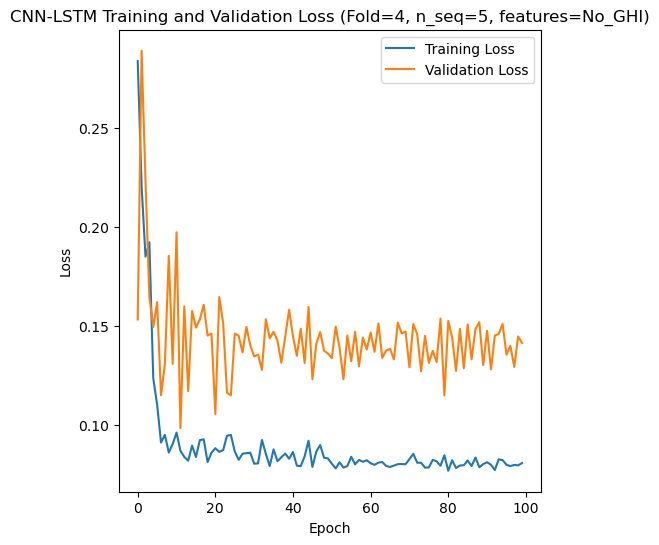

[[0.5275979971256449], [0.5768129695942729], [0.6333981568779605], [0.9999029919854797], [0.6620482466031382]]
[[array(0.527598)], [array(0.57681297)], [array(0.63339816)], [array(0.99990299)], [array(0.66204825)]]
[[0.40719827887415894], [0.426004373133183], [0.5852874402999871], [0.9023683362007144], [0.47917307969927786]]
[[0.02304446159096441], [0.021353390841645038], [0.03788231234157405], [0.06240874660117039], [0.02853297439435838]]
[[0.943043869418351], [0.16358324645495403], [0.8689519160597379], [-10.595448986146716], [0.9774189958609301]]
[[array(0.02304446)], [array(0.02135339)], [array(0.03788231)], [array(0.06240875)], [array(0.02853297)]]
[[array(0.94377611)], [array(0.25206906)], [array(0.89790922)], [array(0.21368874)], [array(0.98323123)]]
[20.77 20.94 20.77 21.01 21.43 17.52 16.69 16.18 16.46 16.29 19.62 19.71
 18.79 19.13 19.97 19.82 20.34 19.95 19.95 21.26 17.6  16.9  17.14 17.11
 17.55 13.84 13.83 13.82 13.36 14.15 14.42 14.47 14.79 14.78 14.49 14.47
 14.35 14.15 

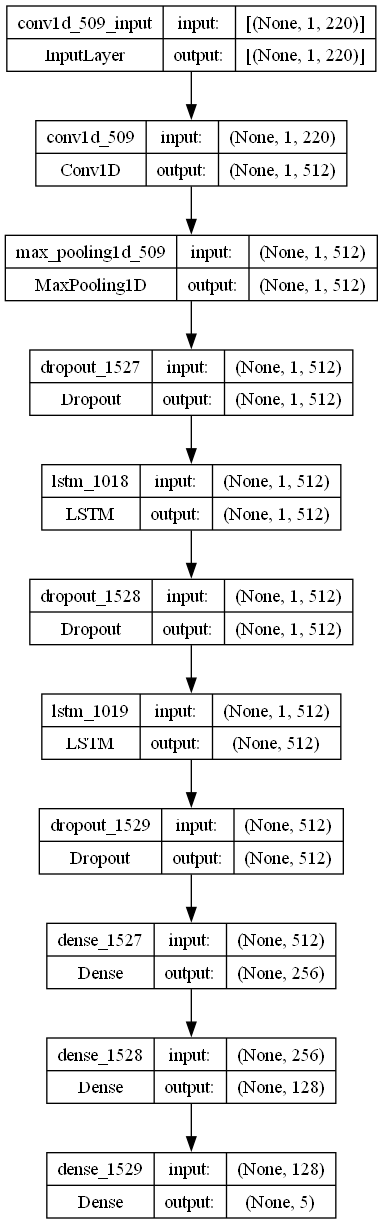

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.002189166216692868 
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.3787894874739706

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S5_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)